# Classifiying if a given drug can be metabolized 

## Libraries

In [ ]:
import os
import math
import xml.etree.ElementTree as ET

import pandas as pd
import numpy as np

from lxml import etree

from rdkit import Chem
from rdkit.Chem import (
    Descriptors, Descriptors3D, Crippen, Lipinski, rdMolDescriptors,
    AllChem, MACCSkeys
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef, classification_report,
    confusion_matrix, precision_recall_fscore_support, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight

from imblearn.combine import SMOTEENN, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE as OverSMOTE

import optuna
from optuna.samplers import TPESampler

import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


## Reading

### Path

In [2]:
xml_path = "drugbank_all_full_database.xml\\full database.xml"

### Understanding the XML File 

In [3]:
all_tags = set()

In [4]:
for event, elem in ET.iterparse(xml_path, events=("start",)):
    all_tags.add(elem.tag)

In [5]:
for tag in sorted(all_tags):
    print(tag)

{http://www.drugbank.ca}absorption
{http://www.drugbank.ca}action
{http://www.drugbank.ca}actions
{http://www.drugbank.ca}adverse-reaction
{http://www.drugbank.ca}affected-organism
{http://www.drugbank.ca}affected-organisms
{http://www.drugbank.ca}ahfs-codes
{http://www.drugbank.ca}allele
{http://www.drugbank.ca}alternative-parent
{http://www.drugbank.ca}amino-acid-sequence
{http://www.drugbank.ca}approved
{http://www.drugbank.ca}article
{http://www.drugbank.ca}articles
{http://www.drugbank.ca}atc-code
{http://www.drugbank.ca}atc-codes
{http://www.drugbank.ca}attachment
{http://www.drugbank.ca}attachments
{http://www.drugbank.ca}average-mass
{http://www.drugbank.ca}calculated-properties
{http://www.drugbank.ca}carrier
{http://www.drugbank.ca}carriers
{http://www.drugbank.ca}cas-number
{http://www.drugbank.ca}categories
{http://www.drugbank.ca}category
{http://www.drugbank.ca}cellular-location
{http://www.drugbank.ca}chromosome-location
{http://www.drugbank.ca}citation
{http://www.drugb

### Reading dataset (the drugs)

In [6]:
context = ET.iterparse(xml_path, events=("start", "end"))
context = iter(context)
event, root = next(context)

In [7]:
tag_prefix = '{http://www.drugbank.ca}' 

In [8]:
data = []

In [9]:
for event, elem in context:
    if event == "end" and elem.tag == f"{tag_prefix}drug":
        drug_ids = elem.findall(f"{tag_prefix}drugbank-id")
        drugbank_id = next((d.text for d in drug_ids if d.attrib.get("primary") == "true"), None)
        if not drugbank_id:
            root.clear()
            continue

        # Basic name
        drug_name_elem = elem.find(f"{tag_prefix}name")
        drug_name = drug_name_elem.text if drug_name_elem is not None else None


        ## Extracting Calculated Properties
        ## Extract smiles separately
        ## Extrcat InCHI separately
        calc_props = {}
        smiles = None
        inchi = None
        calc_elem = elem.find(f"{tag_prefix}calculated-properties")
        if calc_elem is not None:
            for prop in calc_elem.findall(f"{tag_prefix}property"):
                kind = prop.findtext(f"{tag_prefix}kind")
                value = prop.findtext(f"{tag_prefix}value")
                if kind:
                    calc_props[kind.strip()] = value
                if kind == 'SMILES':
                    smiles = value
                if kind == 'InChI':
                    inchi = value

        ## Extracting Experimental Properties
        exp_props = {}
        exp_elem = elem.find(f"{tag_prefix}experimental-properties")
        if exp_elem is not None:
            for prop in exp_elem.findall(f"{tag_prefix}property"):
                kind = prop.findtext(f"{tag_prefix}kind")
                value = prop.findtext(f"{tag_prefix}value")
                if kind:
                    exp_props[kind.strip()] = value
        
        ## Categories
        categories = []
        cats_elem = elem.find(f"{tag_prefix}categories")
        if cats_elem is not None:
            for cat in cats_elem.findall(f"{tag_prefix}category"):
                cat_name = cat.findtext(f"{tag_prefix}category")
                if cat_name:
                    categories.append(cat_name.strip())

        
        ## Affected Organisms

        affected_organisms = []
        affected_elem = elem.find(f"{tag_prefix}affected-organisms")
        if affected_elem is not None:
            for affected in affected_elem.findall(f"{tag_prefix}affected-organism"):
                affected_name = affected.text
                if affected_name:
                    affected_organisms.append(affected_name.strip())
        
        ## Extracting ChEMBL ID
        chembl_id = None
        ext_id_elem = elem.find(f"{tag_prefix}external-identifiers")
        if ext_id_elem is not None:
            for ext_id in ext_id_elem.findall(f"{tag_prefix}external-identifier"):
                resource = ext_id.findtext(f"{tag_prefix}resource")
                identifier = ext_id.findtext(f"{tag_prefix}identifier")
                if resource and resource.strip().lower() == "chembl":
                    chembl_id = identifier.strip()
                    break  

         
        #toxicity

        tox_elem = elem.find(f"{tag_prefix}toxicity")
        toxicity = tox_elem.text if tox_elem is not None else None

        data.append({
                        'drugbank_id': drugbank_id,
                        'drug_name': drug_name,
                        'smiles': smiles,
                        'inchi': inchi,
                        'calculated_properties': calc_props,
                        'experimental_properties': exp_props,
                        'categories': categories,
                        'chembl_id': chembl_id,
                        # 'toxicity':toxicity,
                        'affected_organisms' : affected_organisms

                    })

        root.clear()  # clear memory

In [10]:
df = pd.DataFrame(data)

### Save the dataset

In [11]:
# Save
df.to_csv('drugbank_dataset.csv', index=False)

# Read
# df = pd.read_csv("dataset.csv")

## Dataset Exploration

In [12]:
df

,drugbank_id,drug_name,smiles,inchi,calculated_properties,experimental_properties,categories,chembl_id,affected_organisms
0,DB00001,Lepirudin,None,None,{},"{'Water Solubility': 'Soluble', 'Melting Point...","[Amino Acids, Peptides, and Proteins, Anticoag...",CHEMBL1201666,[Humans and other mammals]
1,DB00002,Cetuximab,None,None,{},"{'Melting Point': '61 °C (FAB fragment), 71 °C...","[Amino Acids, Peptides, and Proteins, Antibodi...",CHEMBL1201577,[Humans and other mammals]
2,DB00003,Dornase alfa,None,None,{},"{'Melting Point': '67 °C', 'Hydrophobicity': '...","[Amino Acids, Peptides, and Proteins, Cough an...",CHEMBL1201431,[Humans and other mammals]
3,DB00004,Denileukin diftitox,None,None,{},"{'Hydrophobicity': '-0.301', 'Isoelectric Poin...","[ADP Ribose Transferases, Amino Acids, Peptide...",CHEMBL1201550,[Humans and other mammals]
4,DB00005,Etanercept,None,None,{},"{'Melting Point': '71 °C (whole mAb)', 'Hydrop...","[Agents reducing cytokine levels, Amino Acids,...",CHEMBL1201572,[Humans and other mammals]
...,...,...,...,...,...,...,...,...,...
17425,DB19452,Exidavnemab,None,None,{},{},[],None,[]
17426,DB19453,Imciromab pentetate,None,None,{},{},"[Amino Acids, Peptides, and Proteins, Antibodi...",None,[]
17427,DB19454,Cetyl oleate,CCCCCCCCCCCCCCCCOC(=O)CCCCCCC\C=C/CCCCCCCC,InChI=1S/C34H66O2/c1-3-5-7-9-11-13-15-17-19-20...,"{'Molecular Weight': '506.9', 'Monoisotopic We...",{},"[Fatty Acids, Lipids]",None,[]
17428,DB19455,Cetyl myristoleate,CCCCCCCCCCCCCCCCOC(=O)CCCCCCC\C=C/CCCC,InChI=1S/C30H58O2/c1-3-5-7-9-11-13-15-16-17-19...,"{'Molecular Weight': '450.792', 'Monoisotopic ...",{},[Lipids],None,[]


In [13]:
df['smiles'].nunique()

12306

In [14]:
print("Number of drugs", len(df))

Number of drugs 17430


In [15]:
print(df.isnull().sum())

drugbank_id                   0
drug_name                     0
smiles                     5117
inchi                      5114
calculated_properties         0
experimental_properties       0
categories                    0
chembl_id                  8620
affected_organisms            0
dtype: int64


### Looking at the properties of the dataset

In [16]:
calc_props = {}
exp_props = {}
drug_categories = set()
drugs_names_with_no_categories = []
drugs_with_no_affected_organisms = []
set_of_organisms = set()

In [17]:
for i in range(len(df)):

    ## for calculated properties
    if df["calculated_properties"].iloc[i] != "{}":
        for key in df["calculated_properties"].iloc[i].keys():
            if key in calc_props:
                calc_props[key] +=1
            else:
                calc_props[key] = 1

    ## for experimental properties
    if df["smiles"].iloc[i] is not None:
        if df["experimental_properties"].iloc[i] != "{}":
            for key in df["experimental_properties"].iloc[i].keys():
                if key in exp_props:
                    exp_props[key] +=1
                else:
                    exp_props[key] = 1
    
    ## for drug categories
    if df["categories"].iloc[i] is not None:
        for key in df["categories"].iloc[i]:
            drug_categories.add(key)
    
    ## for drugs with no categories
    if isinstance(df["categories"].iloc[i], list) and len(df["categories"].iloc[i]) == 0:
        drugs_names_with_no_categories.append(df["drug_name"].iloc[i])

    ## for drugs with no categories
    if isinstance(df["affected_organisms"].iloc[i], list) and len(df["affected_organisms"].iloc[i]) == 0:
        drugs_with_no_affected_organisms.append(df["drug_name"].iloc[i])
    else:
        for key in df["affected_organisms"].iloc[i]:
            set_of_organisms.add(key)
        

In [18]:
## Experiment Properties 
exp_props

{'Water Solubility': 1475,
 'logP': 1453,
 'Melting Point': 1751,
 'Boiling Point': 564,
 'caco2 Permeability': 85,
 'pKa': 613,
 'logS': 202,
 'Radioactivity': 8}

In [19]:
## Calculated Properties
calc_props

{'logP': 11924,
 'logS': 11129,
 'Water Solubility': 11129,
 'IUPAC Name': 11920,
 'Traditional IUPAC Name': 11922,
 'Molecular Weight': 12316,
 'Monoisotopic Weight': 12316,
 'SMILES': 12313,
 'Molecular Formula': 12318,
 'InChI': 12316,
 'InChIKey': 12316,
 'Polar Surface Area (PSA)': 11922,
 'Refractivity': 11922,
 'Polarizability': 11922,
 'Rotatable Bond Count': 11922,
 'H Bond Acceptor Count': 11922,
 'H Bond Donor Count': 11922,
 'pKa (strongest acidic)': 9981,
 'pKa (strongest basic)': 10995,
 'Physiological Charge': 11920,
 'Number of Rings': 11922,
 'Bioavailability': 11922,
 'Rule of Five': 11929,
 'Ghose Filter': 11929,
 'MDDR-Like Rule': 11922}

In [20]:
print("Number of drug categories ",len(drug_categories))

Number of drug categories  4576


In [21]:
drug_categories

{'Cholecystokinin Analog',
 'Bacteriochlorophylls',
 'Agents to Treat Airway Disease',
 'Recombinant Human Nerve Growth Factor',
 'Membrane Lipids',
 'Receptors, Interleukin-8A, antagonists & inhibitors',
 'Cytochrome P-450 CYP2C9 Inducers (weak)',
 'Erythromycins',
 'Recombinant Antithrombin',
 'Deoxyguanosine',
 'Glycolipid Disialoganglioside-directed Antibody Interactions',
 'ADP Ribose Transferases',
 'Decarboxylase Inhibitors',
 'Dihydroxyphenylalanine',
 'GLP-2 Analog',
 'Nuclear Matrix-Associated Proteins',
 'Purine Nucleosides',
 'Direct Acting Antivirals',
 'Human Tetanus Immune Globulins',
 'Immunoglobulin Variable Region',
 'Interleukin-6 Receptor Antagonist',
 'Angiogenesis Modulating Agents',
 'Curare Alkaloids',
 'Phenylethanolamine N-Methyltransferase, antagonists & inhibitors',
 'Interferon gamma Blocker',
 'Agents causing hyperkalemia',
 'OCT1 substrates',
 '4-Quinolones',
 'Adjuvants, Anesthesia',
 'Calcitonin Gene-Related Peptide, antagonists & inhibitors',
 'Leukemi

In [22]:
print("Number of drug with 0 categories ",len(drugs_names_with_no_categories))

Number of drug with 0 categories  7373


In [23]:
drugs_names_with_no_categories

['Lyme disease vaccine (recombinant OspA)',
 'Indecainide',
 'Kava',
 'Dihydroquinidine barbiturate',
 'Quinidine barbiturate',
 '3-Methylthiofentanyl',
 '19-Nor-5-androstenedione',
 'Dimethylthiambutene',
 '19-Nor-4-androstenedione',
 '1-Androstenedione',
 '19-Nor-5-androstenediol',
 '2,5-Dimethoxy-4-(n)-propylthiophenethylamine',
 'Furethidine',
 'Ethylmethylthiambutene',
 'Acetorphine',
 'alpha-methylthiofentanyl',
 'Betaprodine',
 '17alpha-methyl-3beta,17beta-dihydroxyandrost-4-ene',
 'Dioxaphetyl butyrate',
 'Codeine methylbromide',
 'BA-2664',
 'Chloral betaine',
 'Alphamethadol',
 'Alphameprodine',
 'Oxabolone',
 'Diampromide',
 '1-Androstenediol',
 'Etoxeridine',
 'Hydromorphinol',
 '17Alpha-methyl-3beta,17beta-dihydroxy-5alpha-androstane',
 '3,4,5-Trimethoxyamphetamine',
 'Benzethidine',
 'Betacetylmethadol',
 'Clonitazene',
 '4-Androstenediol',
 'Clortermine',
 '4-Methyl-2,5-dimethoxyamphetamine',
 '5alpha-androstane-3alpha,17beta-diol',
 'α-Methylacetylfentanyl',
 '17alpha-m

In [24]:
print("Number of drug with 0 affected organisms ",len(drugs_with_no_affected_organisms))

Number of drug with 0 affected organisms  14727


In [25]:
drugs_with_no_affected_organisms

['Interferon gamma-1b',
 'Interferon beta-1a',
 'Alemtuzumab',
 'Palivizumab',
 'Ketoconazole',
 'Mitiglinide',
 'Glisoxepide',
 'Practolol',
 'Sulfadoxine',
 'Rolitetracycline',
 'Kava',
 "St. John's Wort",
 'Cefradine',
 'Metocurine',
 'Vecuronium',
 'Cilazapril',
 'Dihydroquinidine barbiturate',
 'Potassium cation',
 'Quinidine barbiturate',
 'Tasosartan',
 'Amobarbital',
 'Aprobarbital',
 'Lithium cation',
 'Mestranol',
 'Aluminium',
 'Aluminium monostearate',
 'Magnesium oxide',
 'Magnesium cation',
 'Magnesium salicylate',
 'Choline magnesium trisalicylate',
 'Ginseng',
 'Theobromine',
 'Antrafenine',
 'Nitroxoline',
 'Alizapride',
 'Aprindine',
 'Allylestrenol',
 'Indopan',
 '4-Methylaminorex',
 '19-Nor-4-androstenedione',
 'Dihydroetorphine',
 '1-Androstenedione',
 'Beta-hydroxyfentanyl',
 'Midomafetamine',
 '19-Nor-5-androstenediol',
 '5-androstenedione',
 '2,5-Dimethoxy-4-(n)-propylthiophenethylamine',
 'Bezitramide',
 'Diethyltryptamine',
 'Dimenoxadol',
 'Etonitazene',
 'Fu

In [26]:
### List of all cytochrome categories
cyto_categories = set()
for category in drug_categories:
    if 'cytochrome p-450' in category.lower() or 'cytochrome p450' in category.lower():
        cyto_categories.add(category)

In [27]:
print("Number of different cytochrome p450 categories ", len(cyto_categories))

Number of different cytochrome p450 categories  138


In [28]:
cyto_categories

{'Cytochrome P-450 CYP11B2, antagonists & inhibitors',
 'Cytochrome P-450 CYP1A2 Inducers',
 'Cytochrome P-450 CYP1A2 Inducers (moderate)',
 'Cytochrome P-450 CYP1A2 Inducers (strength unknown)',
 'Cytochrome P-450 CYP1A2 Inducers (strong)',
 'Cytochrome P-450 CYP1A2 Inducers (weak)',
 'Cytochrome P-450 CYP1A2 Inhibitors',
 'Cytochrome P-450 CYP1A2 Inhibitors (moderate)',
 'Cytochrome P-450 CYP1A2 Inhibitors (strength unknown)',
 'Cytochrome P-450 CYP1A2 Inhibitors (strong)',
 'Cytochrome P-450 CYP1A2 Inhibitors (weak)',
 'Cytochrome P-450 CYP1A2 Substrates',
 'Cytochrome P-450 CYP1A2 Substrates with a Narrow Therapeutic Index',
 'Cytochrome P-450 CYP2A6 Inducers',
 'Cytochrome P-450 CYP2A6 Inducers (moderate)',
 'Cytochrome P-450 CYP2A6 Inducers (strong)',
 'Cytochrome P-450 CYP2A6 Inhibitors',
 'Cytochrome P-450 CYP2A6 Inhibitors (moderate)',
 'Cytochrome P-450 CYP2A6 Inhibitors (strength unknown)',
 'Cytochrome P-450 CYP2A6 Inhibitors (strong)',
 'Cytochrome P-450 CYP2A6 Inhibitors 

In [29]:
### Looking at "invalid" entries

In [30]:
invalid_entries = []

In [31]:
def safe_mol_from_smiles(row):
    smiles = row['smiles']
    name = row['drug_name']
    try:
        if isinstance(smiles, str) and smiles.strip():
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                invalid_entries.append((name, smiles))
            return mol
    except Exception:
        invalid_entries.append((name, smiles))
        return None
    return None

In [32]:
df['mol'] = df.apply(safe_mol_from_smiles, axis=1)

[16:48:56] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[16:48:56] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[16:48:56] SMILES Parse Error: check for mistakes around position 84:
[16:48:56] C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O
[16:48:56] ~~~~~~~~~~~~~~~~~~~~^
[16:48:56] SMILES Parse Error: Failed parsing SMILES 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]' for input: 'OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]'
[16:48:56] Explicit valence for atom # 19 O, 2, is greater than permitted
[16:48:56] Explicit valence for atom # 0 O, 3, is greater than perm

In [33]:
print(f"{len(invalid_entries)} invalid SMILES found.\n")
for name, smi in invalid_entries:
    print(f"Drug: {name}")

10 invalid SMILES found.

Drug: 5-Chloryl-2,4,6-quinazolinetriamine
Drug: 5,10,15,20-Tetrakis(4-Sulpfonatophenyl)-21h,23h-Porphine
Drug: Vitamin B 12 factor IIIm
Drug: Tricarbonyl(1,10-phenanthroline)rhenium(1+)
Drug: Tetrafluoroaluminate Ion
Drug: trifluoro-[hydroxy-[hydroxy-[2-(N-methyl-2-nitro-anilino)ethoxy]phosphoryl]oxy-phosphoryl]oxy-beryllium(1-)
Drug: Cyanocobalamin Co-57
Drug: Temoporfin
Drug: Chlorine dioxide
Drug: Borocaptate


### Initial Preprocessing of the dataset

In [34]:
df = df[df['mol'].notnull()].copy()

In [35]:
# Filter for compounds with SMILES
smiles_df = df[df["smiles"].notnull()].copy()
print(f"Compounds with SMILES: {len(smiles_df)}")

Compounds with SMILES: 12303


In [36]:
# Filter for compounds with categories
dataset = smiles_df[smiles_df["categories"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()
print(f"Compounds with categories: {len(dataset)}")

Compounds with categories: 7436


In [37]:
# Create target variable for CYP450 substrate prediction
dataset["is_cyp450_substrate"] = dataset["categories"].apply(
    lambda cats: 1 if isinstance(cats, list) and "Cytochrome P-450 Substrates" in cats else 0
)

In [38]:
print("\nTarget distribution:")
print(dataset["is_cyp450_substrate"].value_counts())


Target distribution:
is_cyp450_substrate
0    6317
1    1119
Name: count, dtype: int64


## Descriptors Computation

### 1. ADMET Calculation

In [39]:
cleaned_df = df[df["smiles"].notnull()].copy()

In [40]:
cleaned_df['mol'] = cleaned_df.apply(safe_mol_from_smiles, axis=1)

[16:48:59] Unusual charge on atom 0 number of radical electrons set to zero
[16:49:00] WARNING: not removing hydrogen atom without neighbors
[16:49:00] WARNING: not removing hydrogen atom without neighbors
[16:49:00] WARNING: not removing hydrogen atom without neighbors
[16:49:00] WARNING: not removing hydrogen atom without neighbors
[16:49:00] WARNING: not removing hydrogen atom without neighbors
[16:49:00] WARNING: not removing hydrogen atom without neighbors
[16:49:00] WARNING: not removing hydrogen atom without neighbors


In [41]:
cleaned_df.shape[0]

12303

I first got all the drug's smiles and then manually put all the data into [ADMETlab 3.0](https://admetmesh.scbdd.com/) and saved it in a new directory

In [42]:
output_dir = "smiles_batches"
os.makedirs(output_dir, exist_ok=True)

In [43]:
df_smiles = cleaned_df[['smiles']]

In [44]:
rows_per_file = 500
num_files = math.ceil(len(df_smiles) / rows_per_file)

for i in range(num_files):
    start = i * rows_per_file
    end = start + rows_per_file
    chunk = df_smiles.iloc[start:end]
    filename = os.path.join(output_dir, f"just_smiles_{i+1}.csv")
    chunk.to_csv(filename, index=False)

PROBLEM IN ADMET CALC THE MOLECULES

- just_smiles_4.csv -> 359
- just_smiles_7.csv -> 143
- just_smiles_8.csv -> 333
- just_smiles_9.csv -> 6
- just_smiles_11.csv -> 85

To overcome this i had manually written "invalid molecule" so as to remove them in data cleaning

In [45]:
# Merge all dataframes
dfs = []

for i in range(1, 26):
    df_temp = pd.read_csv(f"clean_smiles_bacth_values_admet_3/smiles_{i}.csv")
    dfs.append(df_temp)

merged_df = pd.concat(dfs, ignore_index=True)

# Rename 'smiles' column to 'smiles_1' so as to not collide with the orginal dataset's 'smiles'
merged_df = merged_df.rename(columns={'smiles': 'smiles_1'})

In [46]:
cleaned_df_reset = cleaned_df.reset_index(drop=True)
merged_df_reset = merged_df.reset_index(drop=True)

In [47]:
combined_df = pd.concat([cleaned_df_reset, merged_df_reset], axis=1)

In [48]:
df_1 = combined_df.copy()

In [49]:
df_1 = df_1[df_1['categories'].apply(lambda x: len(x) > 0)]

In [50]:
df_1

,drugbank_id,drug_name,smiles,inchi,calculated_properties,experimental_properties,categories,chembl_id,affected_organisms,mol,...,Acute_Aquatic_Toxicity,FAF-Drugs4 Rule,Genotoxic_Carcinogenicity_Mutagenicity,Aggregators,Fluc,Blue_fluorescence,Green_fluorescence,Reactive,Other_assay_interference,Promiscuous
0,DB00006,Bivalirudin,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,"{'logP': '-14', 'logS': '-4.7', 'Water Solubil...",{},"[Amino Acids, Peptides, and Proteins, Anticoag...",CHEMBL2103749,[Humans and other mammals],<rdkit.Chem.rdchem.Mol object at 0x00000201714...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DB00014,Goserelin,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,"{'logP': '-5.1', 'logS': '-4.6', 'Water Solubi...","{'Water Solubility': 'Soluble', 'logP': '-2'}","[Adrenal Cortex Hormones, Amino Acids, Peptide...",CHEMBL1201247,[Humans and other mammals],<rdkit.Chem.rdchem.Mol object at 0x00000201714...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DB00027,Gramicidin D,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,"{'logP': '5.96', 'logS': '-5.7', 'Water Solubi...",{'Melting Point': '229 °C'},"[Amino Acids, Peptides, and Proteins, Anti-Bac...",CHEMBL557217,"[Staphylococcus aureus, Streptococcus agalacti...",<rdkit.Chem.rdchem.Mol object at 0x00000201714...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DB00035,Desmopressin,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,"{'logP': '-6.1', 'logS': '-4', 'Water Solubili...",{},"[Agents that produce hypertension, Amino Acids...",CHEMBL1429,[Humans and other mammals],<rdkit.Chem.rdchem.Mol object at 0x00000201714...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DB00050,Cetrorelix,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,InChI=1S/C70H92ClN17O14/c1-39(2)31-52(61(94)82...,"{'logP': '-1.7', 'logS': '-5.3', 'Water Solubi...",{},"[Amino Acids, Peptides, and Proteins, Anti-Gon...",CHEMBL1200490,[Humans and other mammals],<rdkit.Chem.rdchem.Mol object at 0x00000201714...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12286,DB19384,Propionate ion,CCC([O-])=O,"InChI=1S/C3H6O2/c1-2-3(4)5/h2H2,1H3,(H,4,5)/p-1","{'Molecular Weight': '73.072', 'Monoisotopic W...",{},"[Acids, Acyclic, Fatty Acids, Fatty Acids, Vol...",None,[],<rdkit.Chem.rdchem.Mol object at 0x00000201F53...,...,['-'],['-'],['-'],0.006,0.001,0.007,0.0,1.0,0.344,0.117
12288,DB19386,Miramistin ion,CCCCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC1=CC=CC=C1,InChI=1S/C26H46N2O/c1-4-5-6-7-8-9-10-11-12-13-...,"{'Molecular Weight': '403.674', 'Monoisotopic ...",{},"[Amines, Benzylammonium Compounds, Onium Compo...",CHEMBL4650936,[],<rdkit.Chem.rdchem.Mol object at 0x00000201F53...,...,"[(19, 18, 20, 21, 22)]",['-'],['-'],0.646,0.0,0.004,0.001,0.003,0.725,0.005
12291,DB19419,Azadirachtin,[H][C@@]12OC=C[C@]1(O)[C@@H]1C[C@H](O2)[C@]2(O...,InChI=1S/C35H44O16/c1-8-15(2)24(38)49-18-12-19...,"{'Molecular Weight': '720.721', 'Monoisotopic ...",{},"[Agrochemicals, Azadirachta, Compounds used in...",CHEMBL509309,[],<rdkit.Chem.rdchem.Mol object at 0x00000201F53...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12300,DB19454,Cetyl oleate,CCCCCCCCCCCCCCCCOC(=O)CCCCCCC\C=C/CCCCCCCC,InChI=1S/C34H66O2/c1-3-5-7-9-11-13-15-17-19-20...,"{'Molecular Weight': '506.9', 'Monoisotopic We...",{},"[Fatty Acids, Lipids]",None,[],<rdkit.Chem.rdchem.Mol object at 0x00000201F53...,...,['-'],['-'],['-'],0.649,0.314,0.001,0.005,0.99,0.459,0.324


In [51]:
# Handling those error values from ADMETLab 3.0 
df_1 = df_1[df_1["Acute_Aquatic_Toxicity"] != "Invalid Molecule"]

In [52]:
df_1.shape

(7430, 131)

### 2. 2D Descriptors

In [53]:
def calculate_2d_descriptors_rs(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        
        descriptors = {
            # Constitutional Descriptors
            'MolWt': Descriptors.MolWt(mol),
            'TPSA': Descriptors.TPSA(mol),
            'RotBonds': Descriptors.NumRotatableBonds(mol),
            'HBD': Descriptors.NumHDonors(mol),
            'HBA': Descriptors.NumHAcceptors(mol),
            
            # Topological Descriptors

            'RandicsConnectivity': Descriptors.Chi0v(mol),  # Randic connectivity index
            'BalabanJ': Descriptors.BalabanJ(mol),  # Balaban distance connectivity index
            
            # Electronic Descriptors
            'LogP': Descriptors.MolLogP(mol),  
            'MolMR': Descriptors.MolMR(mol) ,

            # Additional Descriptors

            'FractionCSP3' : Descriptors.FractionCSP3(mol),
            'AvgIpc' :Descriptors.AvgIpc(mol),
            'qed' : Descriptors.qed(mol)
        
        }
        return descriptors
    except Exception as e:
        print(f"Error for {smiles}: {e}")
        return None

In [54]:
def calculate_2d_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        
        descriptors = {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'TPSA': Descriptors.TPSA(mol),
            'HBD': Descriptors.NumHDonors(mol),
            'HBA': Descriptors.NumHAcceptors(mol),
            'RotBonds': Descriptors.NumRotatableBonds(mol),
            'AromaticRings': Descriptors.NumAromaticRings(mol),
            'SaturatedRings': Descriptors.NumSaturatedRings(mol),
            'AliphaticRings': Descriptors.NumAliphaticRings(mol),
            'HeavyAtoms': Descriptors.HeavyAtomCount(mol),
            'FractionCsp3': rdMolDescriptors.CalcFractionCSP3(mol),
            'MolMR': Descriptors.MolMR(mol),
            'BalabanJ': Descriptors.BalabanJ(mol),
            'BertzCT': Descriptors.BertzCT(mol),
            'Chi0': Descriptors.Chi0(mol),
            'Chi1': Descriptors.Chi1(mol),
            'Kappa1': Descriptors.Kappa1(mol),
            'Kappa2': Descriptors.Kappa2(mol),
            'Kappa3': Descriptors.Kappa3(mol)
        }
        return descriptors
    except Exception as e:
        print(f"Error for {smiles}: {e}")
        return None

In [55]:
def calculate_2d_descriptors_all(smiles):
    """
    Calculate all available 2D RDKit descriptors for a given SMILES string.
    
    Args:
        smiles (str): SMILES string of the molecule
        
    Returns:
        dict: Dictionary containing all calculated descriptors, or None if calculation fails
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        
        descriptors = {}
        
        # Constitutional Descriptors
        descriptors['MolWt'] = Descriptors.MolWt(mol)
        descriptors['ExactMolWt'] = Descriptors.ExactMolWt(mol)
        descriptors['HeavyAtomCount'] = Descriptors.HeavyAtomCount(mol)
        descriptors['HeavyAtomMolWt'] = Descriptors.HeavyAtomMolWt(mol)
        descriptors['NumHeteroatoms'] = Descriptors.NumHeteroatoms(mol)
        descriptors['NumHeterocycles'] = Descriptors.NumHeterocycles(mol)
        descriptors['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
        descriptors['NumHDonors'] = Descriptors.NumHDonors(mol)
        descriptors['NumHAcceptors'] = Descriptors.NumHAcceptors(mol)
        descriptors['NHOHCount'] = Descriptors.NHOHCount(mol)
        descriptors['NOCount'] = Descriptors.NOCount(mol)
        descriptors['NumValenceElectrons'] = Descriptors.NumValenceElectrons(mol)
        descriptors['NumRadicalElectrons'] = Descriptors.NumRadicalElectrons(mol)
        
        # Ring Descriptors
        descriptors['RingCount'] = Descriptors.RingCount(mol)
        descriptors['NumAromaticRings'] = Descriptors.NumAromaticRings(mol)
        descriptors['NumSaturatedRings'] = Descriptors.NumSaturatedRings(mol)
        descriptors['NumAliphaticRings'] = Descriptors.NumAliphaticRings(mol)
        descriptors['NumAromaticHeterocycles'] = Descriptors.NumAromaticHeterocycles(mol)
        descriptors['NumSaturatedHeterocycles'] = Descriptors.NumSaturatedHeterocycles(mol)
        descriptors['NumAliphaticHeterocycles'] = Descriptors.NumAliphaticHeterocycles(mol)
        descriptors['NumAromaticCarbocycles'] = Descriptors.NumAromaticCarbocycles(mol)
        descriptors['NumSaturatedCarbocycles'] = Descriptors.NumSaturatedCarbocycles(mol)
        descriptors['NumAliphaticCarbocycles'] = Descriptors.NumAliphaticCarbocycles(mol)
        
        # Stereochemistry Descriptors
        descriptors['NumAtomStereoCenters'] = Descriptors.NumAtomStereoCenters(mol)
        descriptors['NumUnspecifiedAtomStereoCenters'] = Descriptors.NumUnspecifiedAtomStereoCenters(mol)
        descriptors['NumBridgeheadAtoms'] = Descriptors.NumBridgeheadAtoms(mol)
        descriptors['NumSpiroAtoms'] = Descriptors.NumSpiroAtoms(mol)
        
        # Topological Descriptors
        descriptors['BertzCT'] = Descriptors.BertzCT(mol)
        descriptors['HallKierAlpha'] = Descriptors.HallKierAlpha(mol)
        descriptors['Ipc'] = Descriptors.Ipc(mol)
        descriptors['BalabanJ'] = Descriptors.BalabanJ(mol)
        descriptors['Phi'] = Descriptors.Phi(mol)
        descriptors['SPS'] = Descriptors.SPS(mol)
        
        # Connectivity Descriptors
        descriptors['Chi0'] = Descriptors.Chi0(mol)
        descriptors['Chi1'] = Descriptors.Chi1(mol)
        descriptors['Chi0v'] = Descriptors.Chi0v(mol)
        descriptors['Chi1v'] = Descriptors.Chi1v(mol)
        descriptors['Chi2v'] = Descriptors.Chi2v(mol)
        descriptors['Chi3v'] = Descriptors.Chi3v(mol)
        descriptors['Chi4v'] = Descriptors.Chi4v(mol)
        descriptors['Chi0n'] = Descriptors.Chi0n(mol)
        descriptors['Chi1n'] = Descriptors.Chi1n(mol)
        descriptors['Chi2n'] = Descriptors.Chi2n(mol)
        descriptors['Chi3n'] = Descriptors.Chi3n(mol)
        descriptors['Chi4n'] = Descriptors.Chi4n(mol)
        
        # Kappa Shape Descriptors
        descriptors['Kappa1'] = Descriptors.Kappa1(mol)
        descriptors['Kappa2'] = Descriptors.Kappa2(mol)
        descriptors['Kappa3'] = Descriptors.Kappa3(mol)
        
        # Electronic Descriptors
        descriptors['MaxEStateIndex'] = Descriptors.MaxEStateIndex(mol)
        descriptors['MinEStateIndex'] = Descriptors.MinEStateIndex(mol)
        descriptors['MaxAbsEStateIndex'] = Descriptors.MaxAbsEStateIndex(mol)
        descriptors['MinAbsEStateIndex'] = Descriptors.MinAbsEStateIndex(mol)
        descriptors['MaxPartialCharge'] = Descriptors.MaxPartialCharge(mol)
        descriptors['MinPartialCharge'] = Descriptors.MinPartialCharge(mol)
        descriptors['MaxAbsPartialCharge'] = Descriptors.MaxAbsPartialCharge(mol)
        descriptors['MinAbsPartialCharge'] = Descriptors.MinAbsPartialCharge(mol)
        
        # Crippen Descriptors
        descriptors['MolLogP'] = Descriptors.MolLogP(mol)
        descriptors['MolMR'] = Descriptors.MolMR(mol)
        
        # Surface Area Descriptors
        descriptors['TPSA'] = Descriptors.TPSA(mol)
        descriptors['LabuteASA'] = Descriptors.LabuteASA(mol)
        
        # Additional Descriptors
        descriptors['FractionCSP3'] = Descriptors.FractionCSP3(mol)
        descriptors['AvgIpc'] = Descriptors.AvgIpc(mol)
        descriptors['qed'] = Descriptors.qed(mol)
        
        # BCUT Descriptors
        descriptors['BCUT2D_CHGHI'] = Descriptors.BCUT2D_CHGHI(mol)
        descriptors['BCUT2D_CHGLO'] = Descriptors.BCUT2D_CHGLO(mol)
        descriptors['BCUT2D_LOGPHI'] = Descriptors.BCUT2D_LOGPHI(mol)
        descriptors['BCUT2D_LOGPLOW'] = Descriptors.BCUT2D_LOGPLOW(mol)
        descriptors['BCUT2D_MRHI'] = Descriptors.BCUT2D_MRHI(mol)
        descriptors['BCUT2D_MRLOW'] = Descriptors.BCUT2D_MRLOW(mol)
        descriptors['BCUT2D_MWHI'] = Descriptors.BCUT2D_MWHI(mol)
        descriptors['BCUT2D_MWLOW'] = Descriptors.BCUT2D_MWLOW(mol)
        
        # Fingerprint Density Descriptors
        descriptors['FpDensityMorgan1'] = Descriptors.FpDensityMorgan1(mol)
        descriptors['FpDensityMorgan2'] = Descriptors.FpDensityMorgan2(mol)
        descriptors['FpDensityMorgan3'] = Descriptors.FpDensityMorgan3(mol)
        
        # Bond Descriptors
        descriptors['NumAmideBonds'] = Descriptors.NumAmideBonds(mol)
        
        # VSA Descriptors (EState)
        descriptors['EState_VSA1'] = Descriptors.EState_VSA1(mol)
        descriptors['EState_VSA2'] = Descriptors.EState_VSA2(mol)
        descriptors['EState_VSA3'] = Descriptors.EState_VSA3(mol)
        descriptors['EState_VSA4'] = Descriptors.EState_VSA4(mol)
        descriptors['EState_VSA5'] = Descriptors.EState_VSA5(mol)
        descriptors['EState_VSA6'] = Descriptors.EState_VSA6(mol)
        descriptors['EState_VSA7'] = Descriptors.EState_VSA7(mol)
        descriptors['EState_VSA8'] = Descriptors.EState_VSA8(mol)
        descriptors['EState_VSA9'] = Descriptors.EState_VSA9(mol)
        descriptors['EState_VSA10'] = Descriptors.EState_VSA10(mol)
        descriptors['EState_VSA11'] = Descriptors.EState_VSA11(mol)
        
        # VSA Descriptors (PEOE)
        descriptors['PEOE_VSA1'] = Descriptors.PEOE_VSA1(mol)
        descriptors['PEOE_VSA2'] = Descriptors.PEOE_VSA2(mol)
        descriptors['PEOE_VSA3'] = Descriptors.PEOE_VSA3(mol)
        descriptors['PEOE_VSA4'] = Descriptors.PEOE_VSA4(mol)
        descriptors['PEOE_VSA5'] = Descriptors.PEOE_VSA5(mol)
        descriptors['PEOE_VSA6'] = Descriptors.PEOE_VSA6(mol)
        descriptors['PEOE_VSA7'] = Descriptors.PEOE_VSA7(mol)
        descriptors['PEOE_VSA8'] = Descriptors.PEOE_VSA8(mol)
        descriptors['PEOE_VSA9'] = Descriptors.PEOE_VSA9(mol)
        descriptors['PEOE_VSA10'] = Descriptors.PEOE_VSA10(mol)
        descriptors['PEOE_VSA11'] = Descriptors.PEOE_VSA11(mol)
        descriptors['PEOE_VSA12'] = Descriptors.PEOE_VSA12(mol)
        descriptors['PEOE_VSA13'] = Descriptors.PEOE_VSA13(mol)
        descriptors['PEOE_VSA14'] = Descriptors.PEOE_VSA14(mol)
        
        # VSA Descriptors (SMR)
        descriptors['SMR_VSA1'] = Descriptors.SMR_VSA1(mol)
        descriptors['SMR_VSA2'] = Descriptors.SMR_VSA2(mol)
        descriptors['SMR_VSA3'] = Descriptors.SMR_VSA3(mol)
        descriptors['SMR_VSA4'] = Descriptors.SMR_VSA4(mol)
        descriptors['SMR_VSA5'] = Descriptors.SMR_VSA5(mol)
        descriptors['SMR_VSA6'] = Descriptors.SMR_VSA6(mol)
        descriptors['SMR_VSA7'] = Descriptors.SMR_VSA7(mol)
        descriptors['SMR_VSA8'] = Descriptors.SMR_VSA8(mol)
        descriptors['SMR_VSA9'] = Descriptors.SMR_VSA9(mol)
        descriptors['SMR_VSA10'] = Descriptors.SMR_VSA10(mol)
        
        # VSA Descriptors (SlogP)
        descriptors['SlogP_VSA1'] = Descriptors.SlogP_VSA1(mol)
        descriptors['SlogP_VSA2'] = Descriptors.SlogP_VSA2(mol)
        descriptors['SlogP_VSA3'] = Descriptors.SlogP_VSA3(mol)
        descriptors['SlogP_VSA4'] = Descriptors.SlogP_VSA4(mol)
        descriptors['SlogP_VSA5'] = Descriptors.SlogP_VSA5(mol)
        descriptors['SlogP_VSA6'] = Descriptors.SlogP_VSA6(mol)
        descriptors['SlogP_VSA7'] = Descriptors.SlogP_VSA7(mol)
        descriptors['SlogP_VSA8'] = Descriptors.SlogP_VSA8(mol)
        descriptors['SlogP_VSA9'] = Descriptors.SlogP_VSA9(mol)
        descriptors['SlogP_VSA10'] = Descriptors.SlogP_VSA10(mol)
        descriptors['SlogP_VSA11'] = Descriptors.SlogP_VSA11(mol)
        descriptors['SlogP_VSA12'] = Descriptors.SlogP_VSA12(mol)
        
        # VSA Descriptors (VSA_EState)
        descriptors['VSA_EState1'] = Descriptors.VSA_EState1(mol)
        descriptors['VSA_EState2'] = Descriptors.VSA_EState2(mol)
        descriptors['VSA_EState3'] = Descriptors.VSA_EState3(mol)
        descriptors['VSA_EState4'] = Descriptors.VSA_EState4(mol)
        descriptors['VSA_EState5'] = Descriptors.VSA_EState5(mol)
        descriptors['VSA_EState6'] = Descriptors.VSA_EState6(mol)
        descriptors['VSA_EState7'] = Descriptors.VSA_EState7(mol)
        descriptors['VSA_EState8'] = Descriptors.VSA_EState8(mol)
        descriptors['VSA_EState9'] = Descriptors.VSA_EState9(mol)
        descriptors['VSA_EState10'] = Descriptors.VSA_EState10(mol)
        
        # Functional Group Descriptors (fr_*)
        descriptors['fr_Al_COO'] = Descriptors.fr_Al_COO(mol)
        descriptors['fr_Al_OH'] = Descriptors.fr_Al_OH(mol)
        descriptors['fr_Al_OH_noTert'] = Descriptors.fr_Al_OH_noTert(mol)
        descriptors['fr_ArN'] = Descriptors.fr_ArN(mol)
        descriptors['fr_Ar_COO'] = Descriptors.fr_Ar_COO(mol)
        descriptors['fr_Ar_N'] = Descriptors.fr_Ar_N(mol)
        descriptors['fr_Ar_NH'] = Descriptors.fr_Ar_NH(mol)
        descriptors['fr_Ar_OH'] = Descriptors.fr_Ar_OH(mol)
        descriptors['fr_COO'] = Descriptors.fr_COO(mol)
        descriptors['fr_COO2'] = Descriptors.fr_COO2(mol)
        descriptors['fr_C_O'] = Descriptors.fr_C_O(mol)
        descriptors['fr_C_O_noCOO'] = Descriptors.fr_C_O_noCOO(mol)
        descriptors['fr_C_S'] = Descriptors.fr_C_S(mol)
        descriptors['fr_HOCCN'] = Descriptors.fr_HOCCN(mol)
        descriptors['fr_Imine'] = Descriptors.fr_Imine(mol)
        descriptors['fr_NH0'] = Descriptors.fr_NH0(mol)
        descriptors['fr_NH1'] = Descriptors.fr_NH1(mol)
        descriptors['fr_NH2'] = Descriptors.fr_NH2(mol)
        descriptors['fr_N_O'] = Descriptors.fr_N_O(mol)
        descriptors['fr_Ndealkylation1'] = Descriptors.fr_Ndealkylation1(mol)
        descriptors['fr_Ndealkylation2'] = Descriptors.fr_Ndealkylation2(mol)
        descriptors['fr_Nhpyrrole'] = Descriptors.fr_Nhpyrrole(mol)
        descriptors['fr_SH'] = Descriptors.fr_SH(mol)
        descriptors['fr_aldehyde'] = Descriptors.fr_aldehyde(mol)
        descriptors['fr_alkyl_carbamate'] = Descriptors.fr_alkyl_carbamate(mol)
        descriptors['fr_alkyl_halide'] = Descriptors.fr_alkyl_halide(mol)
        descriptors['fr_allylic_oxid'] = Descriptors.fr_allylic_oxid(mol)
        descriptors['fr_amide'] = Descriptors.fr_amide(mol)
        descriptors['fr_amidine'] = Descriptors.fr_amidine(mol)
        descriptors['fr_aniline'] = Descriptors.fr_aniline(mol)
        descriptors['fr_aryl_methyl'] = Descriptors.fr_aryl_methyl(mol)
        descriptors['fr_azide'] = Descriptors.fr_azide(mol)
        descriptors['fr_azo'] = Descriptors.fr_azo(mol)
        descriptors['fr_barbitur'] = Descriptors.fr_barbitur(mol)
        descriptors['fr_benzene'] = Descriptors.fr_benzene(mol)
        descriptors['fr_benzodiazepine'] = Descriptors.fr_benzodiazepine(mol)
        descriptors['fr_bicyclic'] = Descriptors.fr_bicyclic(mol)
        descriptors['fr_diazo'] = Descriptors.fr_diazo(mol)
        descriptors['fr_dihydropyridine'] = Descriptors.fr_dihydropyridine(mol)
        descriptors['fr_epoxide'] = Descriptors.fr_epoxide(mol)
        descriptors['fr_ester'] = Descriptors.fr_ester(mol)
        descriptors['fr_ether'] = Descriptors.fr_ether(mol)
        descriptors['fr_furan'] = Descriptors.fr_furan(mol)
        descriptors['fr_guanido'] = Descriptors.fr_guanido(mol)
        descriptors['fr_halogen'] = Descriptors.fr_halogen(mol)
        descriptors['fr_hdrzine'] = Descriptors.fr_hdrzine(mol)
        descriptors['fr_hdrzone'] = Descriptors.fr_hdrzone(mol)
        descriptors['fr_imidazole'] = Descriptors.fr_imidazole(mol)
        descriptors['fr_imide'] = Descriptors.fr_imide(mol)
        descriptors['fr_isocyan'] = Descriptors.fr_isocyan(mol)
        descriptors['fr_isothiocyan'] = Descriptors.fr_isothiocyan(mol)
        descriptors['fr_ketone'] = Descriptors.fr_ketone(mol)
        descriptors['fr_ketone_Topliss'] = Descriptors.fr_ketone_Topliss(mol)
        descriptors['fr_lactam'] = Descriptors.fr_lactam(mol)
        descriptors['fr_lactone'] = Descriptors.fr_lactone(mol)
        descriptors['fr_methoxy'] = Descriptors.fr_methoxy(mol)
        descriptors['fr_morpholine'] = Descriptors.fr_morpholine(mol)
        descriptors['fr_nitrile'] = Descriptors.fr_nitrile(mol)
        descriptors['fr_nitro'] = Descriptors.fr_nitro(mol)
        descriptors['fr_nitro_arom'] = Descriptors.fr_nitro_arom(mol)
        descriptors['fr_nitro_arom_nonortho'] = Descriptors.fr_nitro_arom_nonortho(mol)
        descriptors['fr_nitroso'] = Descriptors.fr_nitroso(mol)
        descriptors['fr_oxazole'] = Descriptors.fr_oxazole(mol)
        descriptors['fr_oxime'] = Descriptors.fr_oxime(mol)
        descriptors['fr_para_hydroxylation'] = Descriptors.fr_para_hydroxylation(mol)
        descriptors['fr_phenol'] = Descriptors.fr_phenol(mol)
        descriptors['fr_phenol_noOrthoHbond'] = Descriptors.fr_phenol_noOrthoHbond(mol)
        descriptors['fr_phos_acid'] = Descriptors.fr_phos_acid(mol)
        descriptors['fr_phos_ester'] = Descriptors.fr_phos_ester(mol)
        descriptors['fr_piperdine'] = Descriptors.fr_piperdine(mol)
        descriptors['fr_piperzine'] = Descriptors.fr_piperzine(mol)
        descriptors['fr_priamide'] = Descriptors.fr_priamide(mol)
        descriptors['fr_prisulfonamd'] = Descriptors.fr_prisulfonamd(mol)
        descriptors['fr_pyridine'] = Descriptors.fr_pyridine(mol)
        descriptors['fr_quatN'] = Descriptors.fr_quatN(mol)
        descriptors['fr_sulfide'] = Descriptors.fr_sulfide(mol)
        descriptors['fr_sulfonamd'] = Descriptors.fr_sulfonamd(mol)
        descriptors['fr_sulfone'] = Descriptors.fr_sulfone(mol)
        descriptors['fr_term_acetylene'] = Descriptors.fr_term_acetylene(mol)
        descriptors['fr_tetrazole'] = Descriptors.fr_tetrazole(mol)
        descriptors['fr_thiazole'] = Descriptors.fr_thiazole(mol)
        descriptors['fr_thiocyan'] = Descriptors.fr_thiocyan(mol)
        descriptors['fr_thiophene'] = Descriptors.fr_thiophene(mol)
        descriptors['fr_unbrch_alkane'] = Descriptors.fr_unbrch_alkane(mol)
        descriptors['fr_urea'] = Descriptors.fr_urea(mol)
        
        return descriptors
        
    except Exception as e:
        print(f"Error calculating descriptors for {smiles}: {e}")
        return None

In [56]:
descriptors_2d_list = []

for i, smiles in enumerate(df_1['smiles']):
    if i % 1000 == 0:
        print(f"Processed {i}/{len(df_1)} molecules")
    
    desc_2d = calculate_2d_descriptors_rs(smiles)
    descriptors_2d_list.append(desc_2d)  

descriptors_2d_df = pd.DataFrame(descriptors_2d_list)# This will be our "X"

Processed 0/7430 molecules
Processed 1000/7430 molecules
Processed 2000/7430 molecules


[16:49:12] Unusual charge on atom 0 number of radical electrons set to zero
[16:49:12] Unusual charge on atom 0 number of radical electrons set to zero


Processed 3000/7430 molecules
Processed 4000/7430 molecules
Processed 5000/7430 molecules
Processed 6000/7430 molecules


[16:49:49] WARNING: not removing hydrogen atom without neighbors
[16:49:49] WARNING: not removing hydrogen atom without neighbors
[16:49:49] WARNING: not removing hydrogen atom without neighbors
[16:49:49] WARNING: not removing hydrogen atom without neighbors


Processed 7000/7430 molecules


[16:49:56] WARNING: not removing hydrogen atom without neighbors
[16:49:56] WARNING: not removing hydrogen atom without neighbors
[16:49:56] WARNING: not removing hydrogen atom without neighbors
[16:49:56] WARNING: not removing hydrogen atom without neighbors
[16:49:56] WARNING: not removing hydrogen atom without neighbors
[16:49:56] WARNING: not removing hydrogen atom without neighbors
[16:49:56] WARNING: not removing hydrogen atom without neighbors
[16:49:56] WARNING: not removing hydrogen atom without neighbors
[16:49:56] WARNING: not removing hydrogen atom without neighbors
[16:49:56] WARNING: not removing hydrogen atom without neighbors


In [57]:
# Check the shape of your descriptors DataFrame
print(f"descriptors_2d_df shape: {descriptors_2d_df.shape}")

# Check for None values
none_count = sum(1 for x in descriptors_2d_list if x is None)
print(f"Number of None values in descriptors_2d_list: {none_count}")

# Check for NaN values
nan_count = descriptors_2d_df.isnull().sum().sum()
print(f"Number of NaN values in descriptors_2d_df: {nan_count}")

descriptors_2d_df shape: (7430, 12)
Number of None values in descriptors_2d_list: 0
Number of NaN values in descriptors_2d_df: 0


In [58]:
## 3. MACCS Fingerprints

In [59]:
## 4. Morgan Fingerprints

In [60]:
## 5. Daylight Fingerprints

## Dataset Cleaning

In [61]:
## Code to check for missing values
df_1.shape

(7430, 131)

In [62]:
df_1.iloc[:,-1:]

,Promiscuous
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
12286,0.117
12288,0.005
12291,NaN
12300,0.324


In [63]:
descriptors_2d_df

,MolWt,TPSA,RotBonds,HBD,HBA,RandicsConnectivity,BalabanJ,LogP,MolMR,FractionCSP3,AvgIpc,qed
0,2180.317,901.57,66,28,29,85.843918,1.052628,-8.11643,539.8094,0.540816,1.699475,0.014176
1,1269.433,495.89,31,17,16,51.390949,1.242726,-3.10570,328.5382,0.508475,1.843831,0.010267
2,1811.253,519.89,51,20,16,78.097824,1.018536,4.86760,500.1181,0.510417,1.736057,0.022619
3,1069.238,435.41,19,14,15,41.988255,1.680526,-4.13203,271.4037,0.478261,3.846400,0.027501
4,1431.064,495.67,38,17,16,57.980888,1.253762,-0.50613,377.7252,0.428571,1.528241,0.013447
...,...,...,...,...,...,...,...,...,...,...,...,...
7425,73.071,40.13,1,0,2,3.023603,2.847379,-0.85370,15.2980,0.666667,1.378783,0.405179
7426,403.675,29.10,18,1,1,19.555922,1.923560,6.47040,125.8261,0.730769,2.696701,0.220761
7427,720.721,215.34,6,3,16,29.405499,1.398158,-0.20310,164.2794,0.771429,3.471166,0.140161
7428,506.900,26.30,30,0,2,24.977294,3.187828,12.04840,160.7230,0.911765,2.882752,0.054964


In [64]:
descriptors_2d_df.isnull().sum()

MolWt                  0
TPSA                   0
RotBonds               0
HBD                    0
HBA                    0
RandicsConnectivity    0
BalabanJ               0
LogP                   0
MolMR                  0
FractionCSP3           0
AvgIpc                 0
qed                    0
dtype: int64

In [65]:
df_1["is_cyp450_substrate"] = df_1["categories"].apply(
    lambda cats: 1 if "Cytochrome P-450 Substrates" in cats else 0
)

C:\Users\Goutham\AppData\Local\Temp\ipykernel_40696\1854150946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["is_cyp450_substrate"] = df_1["categories"].apply(


In [66]:
final_df = df_1.copy()

In [67]:
print(final_df["is_cyp450_substrate"].value_counts())

is_cyp450_substrate
0    6311
1    1119
Name: count, dtype: int64


In [68]:
## There is a drug with the name water so i am just checking if the merge happened properly
water = 0
for i in range(len(df)):
    if final_df.iloc[i]['drug_name'] == 'Water':
        water = i 
        break

In [69]:
# Sanity Check 
# 'smiles' refers to how the smiles value is in Drugbank XML
# smiles_1' refers to how the smiles value is in ADMETLab3.0
final_df.iloc[water]['smiles'] == final_df.iloc[water]['smiles_1'] 

True

In [70]:
y = final_df.iloc[:, -1]

In [71]:
print(y.value_counts())

is_cyp450_substrate
0    6311
1    1119
Name: count, dtype: int64


## Research Questions B

1) Diff Sampling for RF
2) DT comparisons
3) Fingerprints
4) ADMET
5) Silver Standard (ChemBL)

## 1) Diff Sampling for RF
We will use rdkit descriptors as features and the label will be the target variable. 
Will first
1) Class-weights
2) Oversampling the minority class
3) Undersampling the majority class

The evaluation metrics that we will use are

- Accuracy (Classwise)
- F1-Score
- MCC
- Sensitivity
- Specificity

Dataset will be split into 
- 70 for Training
- 20 for Validation 
- 10 for Testing

In [ ]:
X_all = descriptors_2d_df.copy()
y = final_df['is_cyp450_substrate'].copy()


In [73]:
# Remove constant and near-constant features
variance_selector = VarianceThreshold(threshold=0.01)
X_all = pd.DataFrame(variance_selector.fit_transform(X_all), 
                     columns=X_all.columns[variance_selector.get_support()])

print(f"After removing constant/near-constant features: {X_all.shape}")

After removing constant/near-constant features: (7430, 12)


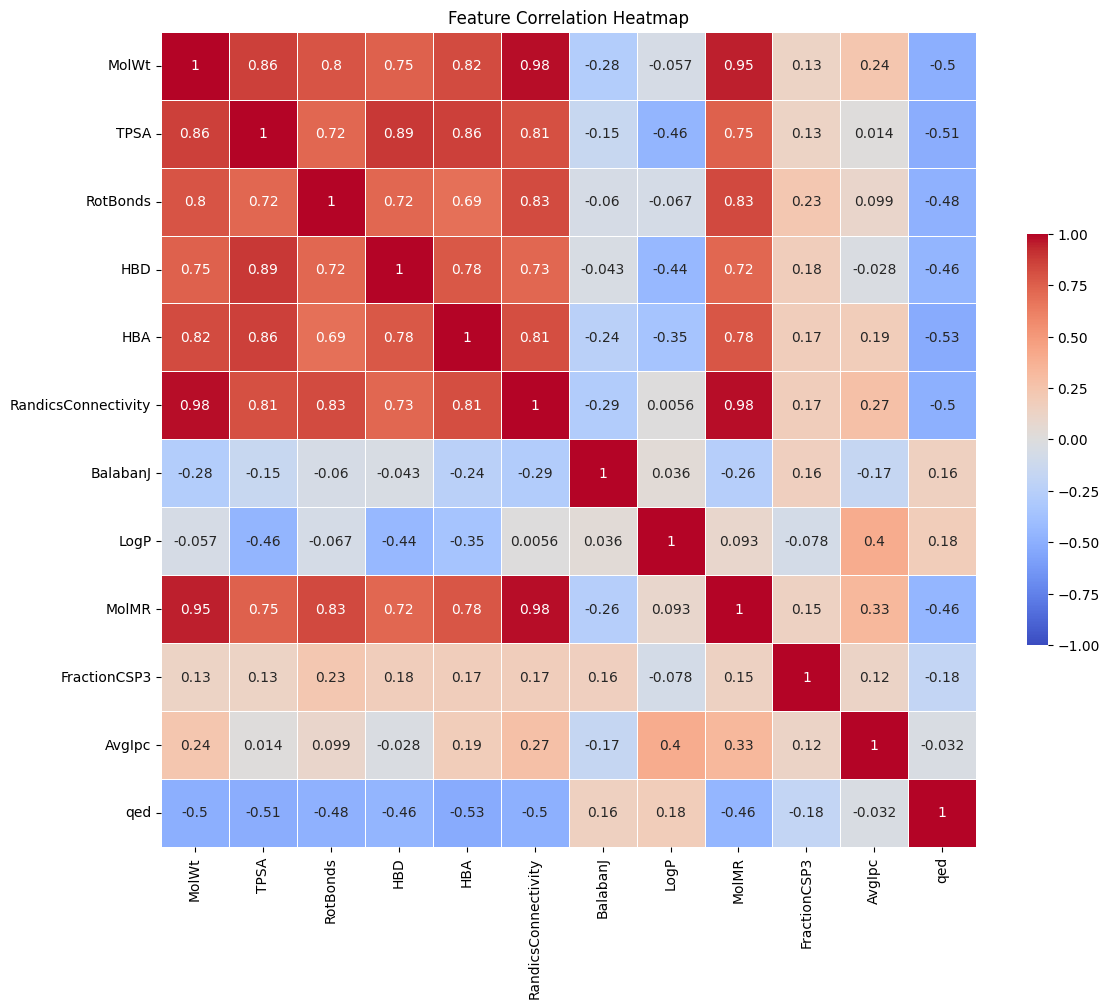

In [74]:
# Compute the correlation matrix
correlation_matrix = X_all.corr()


plt.figure(figsize=(12, 10),)

sns.heatmap(
        correlation_matrix,
        annot=True,            
        cmap='coolwarm',        
        vmin=-1, vmax=1,        
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": .5},
    )

plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


In [75]:
# Remove highly correlated features
correlation_matrix = X_all.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
X_all = X_all.drop(columns=high_corr_features)

print(f"After removing highly correlated features (>0.95): {X_all.shape}")

print(f"Removed {len(high_corr_features)} highly correlated features")

After removing highly correlated features (>0.95): (7430, 10)
Removed 2 highly correlated features


In [76]:
# The Training-Test split 
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X_all, y, test_size=0.15, random_state=42, stratify=y
)

# The Optuna Study Split
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"\nData splits:")
print(f"Training/CV set: {X_train_full.shape[0]} samples")
print(f"Holdout test set: {X_holdout.shape[0]} samples")


print(f"Optuna training set: {X_train_opt.shape[0]} samples")
print(f"Optuna validation set: {X_val_opt.shape[0]} samples")


Data splits:
Training/CV set: 6315 samples
Holdout test set: 1115 samples
Optuna training set: 5052 samples
Optuna validation set: 1263 samples


In [77]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [78]:
def calculate_comprehensive_metrics_fold(y_true, y_pred):

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    
    cm = confusion_matrix(y_true, y_pred)
    class0_accuracy = cm[0, 0] / cm[0].sum() if cm[0].sum() > 0 else 0
    class1_accuracy = cm[1, 1] / cm[1].sum() if cm[1].sum() > 0 else 0
    
    # Specificity = True Negative Rate
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    # Same as recall
    sensitivity = recall
    
    return {
        'accuracy': accuracy, 
        'class0_accuracy': class0_accuracy, 
        'class1_accuracy': class1_accuracy,
        'f1': f1, 
        'mcc': mcc, 
        'sensitivity': sensitivity, 
        'specificity': specificity, 
        'precision': precision
    }

### Class weights

In [79]:
## Optuna function
def objective_class_weights(trial):

   
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8, 0.9])
    max_samples = trial.suggest_float('max_samples', 0.6, 1.0)
    
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_opt), y=y_train_opt)
    weight_dict = {0: class_weights[0], 1: class_weights[1]}
    
    
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_samples=max_samples,
        class_weight=weight_dict,
        random_state=42,
        n_jobs=-1
    )
    
    
    cv_scores = []
    for train_idx, val_idx in skf.split(X_train_opt, y_train_opt):
        X_train_fold = X_train_opt.iloc[train_idx]
        X_val_fold = X_train_opt.iloc[val_idx]
        y_train_fold = y_train_opt.iloc[train_idx]
        y_val_fold = y_train_opt.iloc[val_idx]
        
        rf_model.fit(X_train_fold, y_train_fold)
        y_pred = rf_model.predict(X_val_fold)
        
        # Focus on MCC as primary metric for optimization
        mcc = matthews_corrcoef(y_val_fold, y_pred)
        cv_scores.append(mcc)
    

    return np.mean(cv_scores)

In [80]:
print("\nRunning Random Forest with Class Weights Optuna Study")
study_weights = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='RF_ClassWeights'
)
study_weights.optimize(objective_class_weights, n_trials=100, show_progress_bar=True)

print(f"Best MCC for Class Weights: {study_weights.best_value:.4f}")
print(f"Best parameters: {study_weights.best_params}")

[I 2025-08-24 16:49:59,484] A new study created in memory with name: RF_ClassWeights



Running Random Forest with Class Weights Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-24 16:50:04,158] Trial 0 finished with value: 0.20231177328978484 and parameters: {'n_estimators': 450, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.9, 'max_samples': 0.8404460046972835}. Best is trial 0 with value: 0.20231177328978484.
[I 2025-08-24 16:50:11,928] Trial 1 finished with value: 0.27109860599105184 and parameters: {'n_estimators': 750, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 0.9, 'max_samples': 0.8099025726528951}. Best is trial 1 with value: 0.27109860599105184.
[I 2025-08-24 16:50:17,748] Trial 2 finished with value: 0.19092164024002345 and parameters: {'n_estimators': 500, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 0.9, 'max_samples': 0.6798695128633439}. Best is trial 1 with value: 0.27109860599105184.
[I 2025-08-24 16:50:24,365] Trial 3 finished with value: 0.20986459448095457 and parameters: {'n_estimators': 550, 'max_depth': 34, 'min_sampl

In [81]:
print("\nRandom Forest with Class Weights with best parameters ")
best_params_weights = study_weights.best_params
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_full), y=y_train_full)
weight_dict = {0: class_weights[0], 1: class_weights[1]}

rf_class_weights_optimized = RandomForestClassifier(
    **best_params_weights,
    class_weight=weight_dict,
    random_state=42,
    n_jobs=-1
)
rf_class_weights_optimized.fit(X_train_full, y_train_full)


Random Forest with Class Weights with best parameters 


RandomForestClassifier(class_weight={0: 0.5886465324384788,
                                     1: 3.3201892744479493},
                       max_depth=10, max_features='log2',
                       max_samples=0.8122739356461455, min_samples_leaf=9,
                       min_samples_split=20, n_estimators=900, n_jobs=-1,
                       random_state=42)

### Undersampling

In [82]:
## Optuna function
def objective_undersampling(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8, 0.9])
    max_samples = trial.suggest_float('max_samples', 0.6, 1.0)
    sampling_strategy = trial.suggest_float('sampling_strategy', 0.5, 0.9)
    
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_samples=max_samples,
        random_state=42,
        n_jobs=-1
    )
    
    cv_scores = []
    for train_idx, val_idx in skf.split(X_train_opt, y_train_opt):
        X_train_fold = X_train_opt.iloc[train_idx]
        X_val_fold = X_train_opt.iloc[val_idx]
        y_train_fold = y_train_opt.iloc[train_idx]
        y_val_fold = y_train_opt.iloc[val_idx]
        
        # undersampling
        undersampler = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)
        try:
            X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_fold, y_train_fold)
        except:
            X_train_resampled, y_train_resampled = X_train_fold, y_train_fold
        
        rf_model.fit(X_train_resampled, y_train_resampled)
        y_pred = rf_model.predict(X_val_fold)
        
        mcc = matthews_corrcoef(y_val_fold, y_pred)
        cv_scores.append(mcc)
    
    return np.mean(cv_scores)

In [83]:
print("\nRunning Random Forest Undersampling Optuna Study")
study_under = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='RF_Undersampling'
)
study_under.optimize(objective_undersampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for Undersampling: {study_under.best_value:.4f}")
print(f"Best parameters: {study_under.best_params}")

[I 2025-08-24 17:01:48,888] A new study created in memory with name: RF_Undersampling



Running Random Forest Undersampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-24 17:01:52,839] Trial 0 finished with value: 0.2601593224589712 and parameters: {'n_estimators': 450, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.9, 'max_samples': 0.8404460046972835, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.2601593224589712.
[I 2025-08-24 17:01:54,089] Trial 1 finished with value: 0.22472471954046142 and parameters: {'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.9, 'max_samples': 0.7727780074568463, 'sampling_strategy': 0.6164916560792167}. Best is trial 0 with value: 0.2601593224589712.
[I 2025-08-24 17:01:58,968] Trial 2 finished with value: 0.22942039665646488 and parameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_samples': 0.836965827544817, 'sampling_strategy': 0.5185801650879991}. Best is trial 0 with value: 0.2601593224589712.
[I 2025-08-24 17:02:03

In [84]:
print("\nRandom Forest Undersampling with best parameters ")
best_params_under = study_under.best_params
sampling_strategy_under = best_params_under.pop('sampling_strategy')

undersampler_optimized = RandomUnderSampler(
    random_state=42, 
    sampling_strategy=sampling_strategy_under
)
X_train_under_opt, y_train_under_opt = undersampler_optimized.fit_resample(X_train_full, y_train_full)

rf_undersampling_optimized = RandomForestClassifier(
    **best_params_under,
    random_state=42,
    n_jobs=-1
)
rf_undersampling_optimized.fit(X_train_under_opt, y_train_under_opt)


Random Forest Undersampling with best parameters 


RandomForestClassifier(max_depth=10, max_samples=0.783069303122654,
                       min_samples_leaf=3, min_samples_split=7,
                       n_estimators=450, n_jobs=-1, random_state=42)

### Oversampling

In [85]:
## Optuna Study
def objective_oversampling(trial):

    
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.8, 0.9])
    max_samples = trial.suggest_float('max_samples', 0.6, 1.0)
    sampling_strategy = trial.suggest_float('sampling_strategy', 0.5, 0.9)
    
    
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_samples=max_samples,
        random_state=42,
        n_jobs=-1
    )
    
    cv_scores = []
    for train_idx, val_idx in skf.split(X_train_opt, y_train_opt):
        X_train_fold = X_train_opt.iloc[train_idx]
        X_val_fold = X_train_opt.iloc[val_idx]
        y_train_fold = y_train_opt.iloc[train_idx]
        y_val_fold = y_train_opt.iloc[val_idx]
        
        #  oversampling
        smoteenn = SMOTEENN(random_state=42, sampling_strategy=sampling_strategy, smote=None)
        try:
            X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train_fold, y_train_fold)
        except:
            X_train_resampled, y_train_resampled = X_train_fold, y_train_fold
        
        rf_model.fit(X_train_resampled, y_train_resampled)
        y_pred = rf_model.predict(X_val_fold)
        
        mcc = matthews_corrcoef(y_val_fold, y_pred)
        cv_scores.append(mcc)
    
    return np.mean(cv_scores)

In [86]:
print("\nOptimizing Random Forest with Oversampling...")
study_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='RF_Oversampling'
)
study_over.optimize(objective_oversampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for Oversampling: {study_over.best_value:.4f}")
print(f"Best parameters: {study_over.best_params}")

[I 2025-08-24 17:08:10,511] A new study created in memory with name: RF_Oversampling



Optimizing Random Forest with Oversampling...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-24 17:08:16,248] Trial 0 finished with value: 0.2466345067689934 and parameters: {'n_estimators': 450, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.9, 'max_samples': 0.8404460046972835, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.2466345067689934.
[I 2025-08-24 17:08:17,750] Trial 1 finished with value: 0.19925322542458396 and parameters: {'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.9, 'max_samples': 0.7727780074568463, 'sampling_strategy': 0.6164916560792167}. Best is trial 0 with value: 0.2466345067689934.
[I 2025-08-24 17:08:23,204] Trial 2 finished with value: 0.1802093325265295 and parameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_samples': 0.836965827544817, 'sampling_strategy': 0.5185801650879991}. Best is trial 0 with value: 0.2466345067689934.
[I 2025-08-24 17:08:29,

In [87]:
best_params_over = study_over.best_params
sampling_strategy_over = best_params_over.pop('sampling_strategy')

smoteenn_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_opt, y_train_over_opt = smoteenn_optimized.fit_resample(X_train_full, y_train_full)

rf_oversampling_optimized = RandomForestClassifier(
    **best_params_over,
    random_state=42,
    n_jobs=-1
)
rf_oversampling_optimized.fit(X_train_over_opt, y_train_over_opt)

RandomForestClassifier(max_depth=10, max_samples=0.9553331356747163,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=250, n_jobs=-1, random_state=42)

### Testing 

In [88]:
# Model predictions on holdout set
weights_holdout_pred_opt = rf_class_weights_optimized.predict(X_holdout)
under_holdout_pred_opt = rf_undersampling_optimized.predict(X_holdout)
over_holdout_pred_opt = rf_oversampling_optimized.predict(X_holdout)

In [89]:
# Calculate holdout metrics
holdout_results_opt = {}
holdout_results_opt['RF_ClassWeights_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, weights_holdout_pred_opt)
holdout_results_opt['RF_Undersampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, under_holdout_pred_opt)
holdout_results_opt['RF_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, over_holdout_pred_opt)

holdout_summary_opt_df = pd.DataFrame(holdout_results_opt).T
print("Random Forest Holdout test results")
print(holdout_summary_opt_df.round(4))

Random Forest Holdout test results
                            accuracy  class0_accuracy  class1_accuracy  \
RF_ClassWeights_Optimized     0.6368           0.6325           0.6607   
RF_Undersampling_Optimized    0.6278           0.6199           0.6726   
RF_Oversampling_Optimized     0.6117           0.5924           0.7202   

                                f1     mcc  sensitivity  specificity  \
RF_ClassWeights_Optimized   0.3541  0.2132       0.6607       0.6325   
RF_Undersampling_Optimized  0.3526  0.2117       0.6726       0.6199   
RF_Oversampling_Optimized   0.3585  0.2246       0.7202       0.5924   

                            precision  
RF_ClassWeights_Optimized      0.2418  
RF_Undersampling_Optimized     0.2389  
RF_Oversampling_Optimized      0.2387  


### RQ-1 Conclusion

In [90]:
print("RQ-1 Conclusion")

print("Best Optuna CV Scores (MCC):")
print(f"Class Weights: {study_weights.best_value:.4f}")
print(f"Undersampling: {study_under.best_value:.4f}")
print(f"Oversampling: {study_over.best_value:.4f}")

print(f"\nBest performing optimized model: {holdout_summary_opt_df['mcc'].idxmax()}")
print(f"Holdout MCC: {holdout_summary_opt_df['mcc'].max():.4f}")
print(f"Holdout Class 1 accuracy: {holdout_summary_opt_df['class1_accuracy'].max():.4f}")
print(f"Holdout F1 score: {holdout_summary_opt_df['f1'].max():.4f}")

RQ-1 Conclusion
Best Optuna CV Scores (MCC):
Class Weights: 0.2717
Undersampling: 0.2759
Oversampling: 0.2754

Best performing optimized model: RF_Oversampling_Optimized
Holdout MCC: 0.2246
Holdout Class 1 accuracy: 0.7202
Holdout F1 score: 0.3585


### RQ -1 Model Analysis

In [91]:
best_model = rf_oversampling_optimized  
X_analysis = X_train_full  
y_analysis = y_train_full 

In [92]:
feature_importance = best_model.feature_importances_
feature_names = X_analysis.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)


In [93]:
print(f"Number of features: {len(importance_df)}")
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

Number of features: 10

Top 10 Most Important Features:
        Feature  Importance
6          LogP    0.280466
8        AvgIpc    0.135539
3           HBD    0.113474
0         MolWt    0.110520
1          TPSA    0.077164
9           qed    0.075106
7  FractionCSP3    0.062074
2      RotBonds    0.057406
5      BalabanJ    0.053439
4           HBA    0.034813


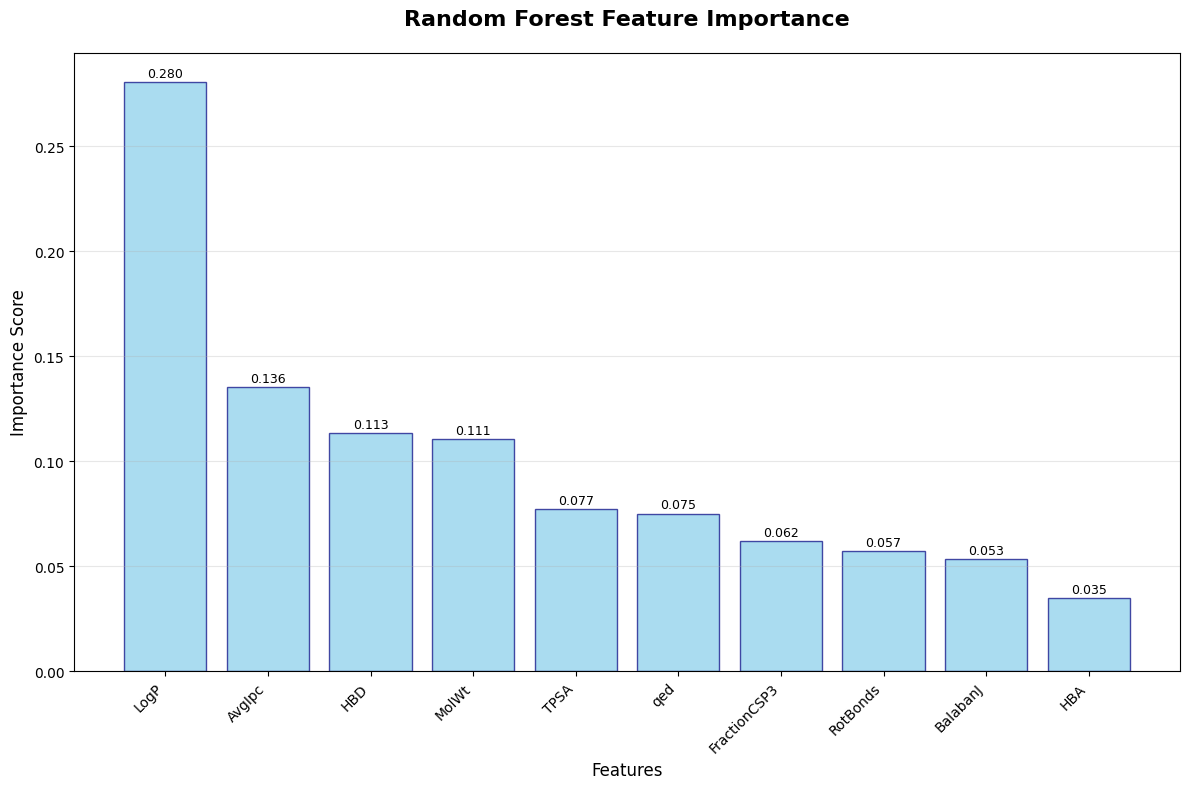

In [94]:
# Create the feature importance plot
plt.figure(figsize=(12, 8))

bars = plt.bar(range(len(importance_df)), importance_df['Importance'], 
               color='skyblue', edgecolor='navy', alpha=0.7)

plt.title('Random Forest Feature Importance', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)

x_labels = []
for i in range(len(importance_df)):
    if i < 10:  
        x_labels.append(importance_df.iloc[i]['Feature'])
    else:
        x_labels.append(f'F{i+1}')

plt.xticks(range(len(importance_df)), x_labels, rotation=45, ha='right')

for i, bar in enumerate(bars[:10]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')

## 2 DT Comparisons 
- RF 
- XGboost
- LightBGM

Sampling method (Oversampling)

### XGboost

In [95]:
def objective_xgb_oversampling(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.6, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.001, 10.0, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 0.001, 10.0, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    sampling_strategy = trial.suggest_float('sampling_strategy', 0.5, 0.9)
    
    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        colsample_bylevel=colsample_bylevel,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        min_child_weight=min_child_weight,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    cv_scores = []
    for train_idx, val_idx in skf.split(X_train_opt, y_train_opt):
        X_train_fold = X_train_opt.iloc[train_idx]
        X_val_fold = X_train_opt.iloc[val_idx]
        y_train_fold = y_train_opt.iloc[train_idx]
        y_val_fold = y_train_opt.iloc[val_idx]
        
        smoteenn = SMOTEENN(random_state=42, sampling_strategy=sampling_strategy, smote=None)
        try:
            X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train_fold, y_train_fold)
        except:
            X_train_resampled, y_train_resampled = X_train_fold, y_train_fold
        
        xgb_model.fit(X_train_resampled, y_train_resampled)
        y_pred = xgb_model.predict(X_val_fold)
        
        mcc = matthews_corrcoef(y_val_fold, y_pred)
        cv_scores.append(mcc)
    
    return np.mean(cv_scores)

In [96]:
print("\nRunning XGBoost Oversampling Optuna Study")
study_xgb_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='XGB_Oversampling'
)
study_xgb_over.optimize(objective_xgb_oversampling, n_trials=100, show_progress_bar=True)

[I 2025-08-24 17:16:03,814] A new study created in memory with name: XGB_Oversampling



Running XGBoost Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-24 17:16:06,294] Trial 0 finished with value: 0.20493315576187507 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'colsample_bylevel': 0.662397808134481, 'reg_alpha': 0.0017073967431528124, 'reg_lambda': 2.9154431891537547, 'min_child_weight': 7, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.20493315576187507.
[I 2025-08-24 17:16:06,971] Trial 1 finished with value: 0.20869960729321568 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'colsample_bylevel': 0.6733618039413735, 'reg_alpha': 0.016480446427978974, 'reg_lambda': 0.12561043700013558, 'min_child_weight': 5, 'sampling_strategy': 0.6164916560792167}. Best is trial 1 with value: 0.20869960729321568.
[I 2025-08-24 17:16:08,602] Trial 2 finished with value: 0.1692453

In [97]:
best_params_xgb_over = study_xgb_over.best_params.copy()
sampling_strategy_over = best_params_xgb_over.pop('sampling_strategy')

smoteenn_xgb_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_xgb_opt, y_train_over_xgb_opt = smoteenn_xgb_optimized.fit_resample(X_train_full, y_train_full)

xgb_oversampling_optimized = XGBClassifier(
    **best_params_xgb_over,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_oversampling_optimized.fit(X_train_over_xgb_opt, y_train_over_xgb_opt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7927285355197659, colsample_bynode=None,
              colsample_bytree=0.9519335273977294, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010044240798950554,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=450, n_jobs=-1,
              num_parallel_tree=None, ...)

### LightBGM

In [98]:
def objective_lgb_oversampling(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=50)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    reg_alpha = trial.suggest_float('reg_alpha', 0.001, 10.0, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 0.001, 10.0, log=True)
    min_child_samples = trial.suggest_int('min_child_samples', 10, 100)
    min_child_weight = trial.suggest_float('min_child_weight', 0.001, 10.0, log=True)
    sampling_strategy = trial.suggest_float('sampling_strategy', 0.5, 0.9)
    
    lgb_model = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        min_child_samples=min_child_samples,
        min_child_weight=min_child_weight,
        random_state=42,
        n_jobs=-1,
        verbose=-1,  
        objective='binary'
    )
    
    
    cv_scores = []
    for train_idx, val_idx in skf.split(X_train_opt, y_train_opt):
        X_train_fold = X_train_opt.iloc[train_idx]
        X_val_fold = X_train_opt.iloc[val_idx]
        y_train_fold = y_train_opt.iloc[train_idx]
        y_val_fold = y_train_opt.iloc[val_idx]
        
        smoteenn = SMOTEENN(random_state=42, sampling_strategy=sampling_strategy, smote=None)
        try:
            X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train_fold, y_train_fold)
        except:
            X_train_resampled, y_train_resampled = X_train_fold, y_train_fold
        
        lgb_model.fit(X_train_resampled, y_train_resampled)
        y_pred = lgb_model.predict(X_val_fold)
        
        mcc = matthews_corrcoef(y_val_fold, y_pred)
        cv_scores.append(mcc)
    
    return np.mean(cv_scores)

In [99]:
print("\nRunning LightGBM Oversampling Optuna Study")
study_lgb_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='LGB_Oversampling'
)
study_lgb_over.optimize(objective_lgb_oversampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for LightGBM Oversampling: {study_lgb_over.best_value:.4f}")
print(f"Best parameters: {study_lgb_over.best_params}")

[I 2025-08-24 17:18:08,576] A new study created in memory with name: LGB_Oversampling



Running LightGBM Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-24 17:18:10,490] Trial 0 finished with value: 0.18606617018319876 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.004207053950287938, 'reg_lambda': 0.0017073967431528124, 'min_child_samples': 88, 'min_child_weight': 0.2537815508265665, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.18606617018319876.
[I 2025-08-24 17:18:11,172] Trial 1 finished with value: 0.18200749844274605 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_alpha': 0.00541524411940254, 'reg_lambda': 0.016480446427978974, 'min_child_samples': 57, 'min_child_weight': 0.05342937261279776, 'sampling_strategy': 0.6164916560792167}. Best is trial 0 with value: 0.18606617018319876.
[I 2025-08-24 17:18:12,653] Trial 2 finished with value: 0.1

In [100]:
print("\nTraining LightGBM with Oversampling (best parameters)")
best_params_lgb_over = study_lgb_over.best_params.copy()
sampling_strategy_over = best_params_lgb_over.pop('sampling_strategy')

smoteenn_lgb_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_lgb_opt, y_train_over_lgb_opt = smoteenn_lgb_optimized.fit_resample(X_train_full, y_train_full)

lgb_oversampling_optimized = LGBMClassifier(
    **best_params_lgb_over,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    objective='binary'
)
lgb_oversampling_optimized.fit(X_train_over_lgb_opt, y_train_over_lgb_opt)


Training LightGBM with Oversampling (best parameters)


LGBMClassifier(colsample_bytree=0.6006086939444497,
               learning_rate=0.013748213822390092, max_depth=6,
               min_child_samples=40, min_child_weight=0.002388175175066089,
               n_estimators=250, objective='binary', random_state=42,
               reg_alpha=0.06399101869834797, reg_lambda=0.43145312659036544,
               subsample=0.6651251694386118, verbose=-1)

### Testing 

In [101]:
# Model predictions on holdout set

xgb_over_holdout_pred_opt = xgb_oversampling_optimized.predict(X_holdout)
rf_over_holdout_pred_opt = rf_oversampling_optimized.predict(X_holdout)
lgb_over_holdout_pred_opt = lgb_oversampling_optimized.predict(X_holdout)


In [102]:
dt_holdout_results_opt = {}


dt_holdout_results_opt['RF_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, rf_over_holdout_pred_opt)
dt_holdout_results_opt['XGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, xgb_over_holdout_pred_opt)
dt_holdout_results_opt['LGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, lgb_over_holdout_pred_opt)

dt_holdout_summary_opt_df = pd.DataFrame(dt_holdout_results_opt).T
print("Decision Trees Holdout test results")
print(dt_holdout_summary_opt_df.round(4))


Decision Trees Holdout test results
                            accuracy  class0_accuracy  class1_accuracy  \
RF_Oversampling_Optimized     0.6117           0.5924           0.7202   
XGB_Oversampling_Optimized    0.6117           0.5987           0.6845   
LGB_Oversampling_Optimized    0.6170           0.5977           0.7262   

                                f1     mcc  sensitivity  specificity  \
RF_Oversampling_Optimized   0.3585  0.2246       0.7202       0.5924   
XGB_Oversampling_Optimized  0.3469  0.2039       0.6845       0.5987   
LGB_Oversampling_Optimized  0.3636  0.2328       0.7262       0.5977   

                            precision  
RF_Oversampling_Optimized      0.2387  
XGB_Oversampling_Optimized     0.2323  
LGB_Oversampling_Optimized     0.2425  


In [103]:
print(f"\nBest performing optimized model: {dt_holdout_summary_opt_df['mcc'].idxmax()}")
print(f"Holdout MCC: {dt_holdout_summary_opt_df['mcc'].max():.4f}")
print(f"Holdout Class 1 accuracy: {dt_holdout_summary_opt_df['class1_accuracy'].max():.4f}")
print(f"Holdout F1 score: {dt_holdout_summary_opt_df['f1'].max():.4f}")


Best performing optimized model: LGB_Oversampling_Optimized
Holdout MCC: 0.2328
Holdout Class 1 accuracy: 0.7262
Holdout F1 score: 0.3636


### RQ -2 Model Analysis

In [104]:
best_model = lgb_oversampling_optimized  
X_analysis = X_train_full  
y_analysis = y_train_full 

In [105]:
feature_importance = best_model.feature_importances_
feature_names = X_analysis.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)


In [106]:
print(f"Number of features: {len(importance_df)}")
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

Number of features: 10

Top 10 Most Important Features:
        Feature  Importance
3           HBD         955
0         MolWt         796
1          TPSA         740
6          LogP         623
7  FractionCSP3         562
8        AvgIpc         532
2      RotBonds         531
9           qed         524
5      BalabanJ         468
4           HBA         393


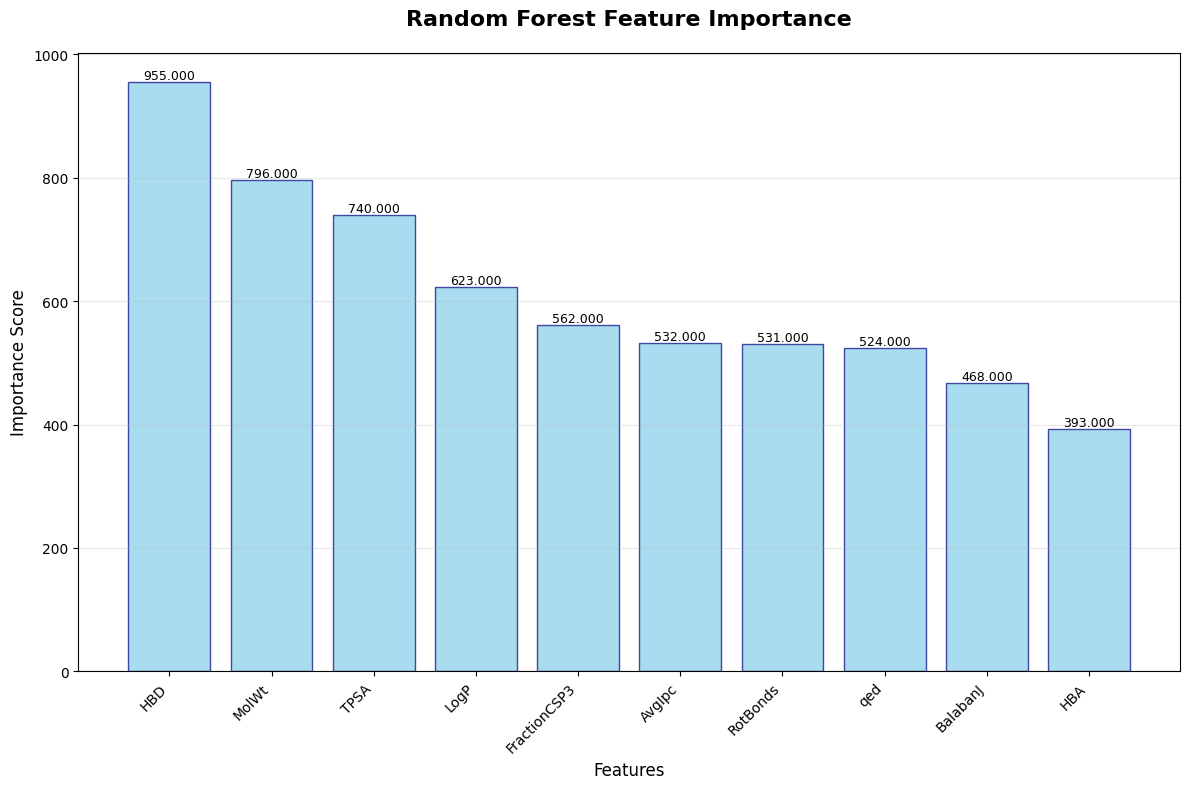

In [107]:
# Create the feature importance plot
plt.figure(figsize=(12, 8))

bars = plt.bar(range(len(importance_df)), importance_df['Importance'], 
               color='skyblue', edgecolor='navy', alpha=0.7)

plt.title('Random Forest Feature Importance', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)

x_labels = []
for i in range(len(importance_df)):
    if i < 10:  
        x_labels.append(importance_df.iloc[i]['Feature'])
    else:
        x_labels.append(f'F{i+1}')

plt.xticks(range(len(importance_df)), x_labels, rotation=45, ha='right')

for i, bar in enumerate(bars[:10]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')

## 3 ) Different Fingerprints 
- Morgan (ECFP)
- MACCS 
- Daylight-like

In [182]:
def compute_maccs_fingerprints(mol):
    try:
        if mol is None:
            return np.zeros(167)
        
        maccs = MACCSkeys.GenMACCSKeys(mol)
        # Convert to numpy array
        return np.array(maccs)
    except Exception as e:
        print(f"Error computing MACCS fingerprint: {e}")
        return np.zeros(167)

# Compute MACCS fingerprints
maccs_fps = final_df['mol'].apply(compute_maccs_fingerprints)
maccs_array = np.vstack(maccs_fps.values)
maccs_df = pd.DataFrame(maccs_array, columns=[f'MACCS_{i}' for i in range(167)])

MACCS fingerprints computed: 167 features for 7430 compounds


In [198]:
print(f"MACCS fingerprints computed: {maccs_df.shape[1]} features for {maccs_df.shape[0]} compounds")

MACCS fingerprints computed: 167 features for 7430 compounds


In [ ]:
def compute_morgan_fingerprints(mol, radius=2, nBits=2048):
    try:
        if mol is None:
            return np.zeros(nBits)
        
        morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        return np.array(morgan_fp)
    except Exception as e:
        print(f"Error computing Morgan fingerprint: {e}")
        return np.zeros(nBits)

# Assuming final_df['mol'] contains RDKit molecule objects
morgan_fps = final_df['mol'].apply(lambda x: compute_morgan_fingerprints(x, radius=2, nBits=2048))
morgan_array = np.vstack(morgan_fps.values)
morgan_df = pd.DataFrame(morgan_array, columns=[f'Morgan_{i}' for i in range(2048)])

[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerator
[22:24:23] DEPRECATION WARNING: please use MorganGenerat

In [197]:
print(f"Morgan fingerprints computed: {morgan_df.shape[1]} features for {morgan_df.shape[0]} compounds")

Morgan fingerprints computed: 2048 features for 7430 compounds


In [199]:
def compute_daylight_fingerprints(mol, minPath=1, maxPath=7, fpSize=2048):
    try:
        if mol is None:
            return np.zeros(fpSize)
        
        daylight_fp = Chem.RDKFingerprint(mol, minPath=minPath, maxPath=maxPath, fpSize=fpSize)
        return np.array(daylight_fp)
    except Exception as e:
        print(f"Error computing Daylight fingerprint: {e}")
        return np.zeros(fpSize)

# Assuming final_df['mol'] contains RDKit molecule objects
daylight_fps = final_df['mol'].apply(lambda x: compute_daylight_fingerprints(x, minPath=1, maxPath=7, fpSize=2048))
daylight_array = np.vstack(daylight_fps.values)
daylight_df = pd.DataFrame(daylight_array, columns=[f'Daylight_{i}' for i in range(2048)])

In [200]:
print(f"Daylight fingerprints computed: {daylight_df.shape[1]} features for {daylight_df.shape[0]} compounds")

Daylight fingerprints computed: 2048 features for 7430 compounds


In [201]:
MACCS_DF = pd.concat([descriptors_2d_df, maccs_df], axis=1)
MORGAN_DF = pd.concat([descriptors_2d_df, morgan_df], axis=1)
DAYLIGHT_DF = pd.concat([descriptors_2d_df, daylight_df], axis=1)

### MACCS

In [ ]:
X_all = MACCS_DF.copy()
y = final_df['is_cyp450_substrate'].copy()

In [204]:
X_all.shape

(7430, 160)

In [203]:
variance_selector = VarianceThreshold(threshold=0.01)
X_all = pd.DataFrame(variance_selector.fit_transform(X_all), 
                     columns=X_all.columns[variance_selector.get_support()])

print(f"After removing constant/near-constant features: {X_all.shape}")

After removing constant/near-constant features: (7430, 160)


In [205]:
# Remove highly correlated features
correlation_matrix = X_all.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
X_all = X_all.drop(columns=high_corr_features)

print(f"After removing highly correlated features (>0.95): {X_all.shape}")
print(f"Removed {len(high_corr_features)} highly correlated features")

After removing highly correlated features (>0.95): (7430, 151)
Removed 9 highly correlated features


In [206]:
# The Training-Test split 
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X_all, y, test_size=0.15, random_state=42, stratify=y
)

# The Optuna Study Split
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"\nData splits:")
print(f"Training/CV set: {X_train_full.shape[0]} samples")
print(f"Holdout test set: {X_holdout.shape[0]} samples")


print(f"Optuna training set: {X_train_opt.shape[0]} samples")
print(f"Optuna validation set: {X_val_opt.shape[0]} samples")


Data splits:
Training/CV set: 6315 samples
Holdout test set: 1115 samples
Optuna training set: 5052 samples
Optuna validation set: 1263 samples


#### Rf

In [207]:
print("\nRunning Random Forest Oversampling Optuna Study")
study_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='RF_Oversampling'
)
study_over.optimize(objective_oversampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for Oversampling: {study_over.best_value:.4f}")
print(f"Best parameters: {study_over.best_params}")

[I 2025-08-24 23:53:07,557] A new study created in memory with name: RF_Oversampling



Running Random Forest Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-24 23:53:22,147] Trial 0 finished with value: 0.25890588250247476 and parameters: {'n_estimators': 450, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.9, 'max_samples': 0.8404460046972835, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.25890588250247476.
[I 2025-08-24 23:53:25,584] Trial 1 finished with value: 0.25217412572095177 and parameters: {'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.9, 'max_samples': 0.7727780074568463, 'sampling_strategy': 0.6164916560792167}. Best is trial 0 with value: 0.25890588250247476.
[I 2025-08-24 23:53:33,669] Trial 2 finished with value: 0.22836011829929945 and parameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_samples': 0.836965827544817, 'sampling_strategy': 0.5185801650879991}. Best is trial 0 with value: 0.25890588250247476.
[I 2025-08-24 23:5

In [208]:
best_params_over = study_over.best_params
sampling_strategy_over = best_params_over.pop('sampling_strategy')

smoteenn_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_opt, y_train_over_opt = smoteenn_optimized.fit_resample(X_train_full, y_train_full)

rf_oversampling_optimized = RandomForestClassifier(
    **best_params_over,
    random_state=42,
    n_jobs=-1
)
rf_oversampling_optimized.fit(X_train_over_opt, y_train_over_opt)

RandomForestClassifier(max_depth=32, max_samples=0.8116816363084741,
                       min_samples_leaf=5, min_samples_split=5,
                       n_estimators=300, n_jobs=-1, random_state=42)

#### Xgboost

In [210]:
print("\nRunning XGBoost Oversampling Optuna Study")
study_xgb_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='XGB_Oversampling'
)
study_xgb_over.optimize(objective_xgb_oversampling, n_trials=100, show_progress_bar=True)

[I 2025-08-25 00:59:30,331] A new study created in memory with name: XGB_Oversampling



Running XGBoost Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-25 00:59:46,075] Trial 0 finished with value: 0.23955408238104625 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'colsample_bylevel': 0.662397808134481, 'reg_alpha': 0.0017073967431528124, 'reg_lambda': 2.9154431891537547, 'min_child_weight': 7, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.23955408238104625.
[I 2025-08-25 00:59:53,599] Trial 1 finished with value: 0.232822685962044 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'colsample_bylevel': 0.6733618039413735, 'reg_alpha': 0.016480446427978974, 'reg_lambda': 0.12561043700013558, 'min_child_weight': 5, 'sampling_strategy': 0.6164916560792167}. Best is trial 0 with value: 0.23955408238104625.
[I 2025-08-25 01:00:11,851] Trial 2 finished with value: 0.240539018

In [211]:
best_params_xgb_over = study_xgb_over.best_params.copy()
sampling_strategy_over = best_params_xgb_over.pop('sampling_strategy')

smoteenn_xgb_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_xgb_opt, y_train_over_xgb_opt = smoteenn_xgb_optimized.fit_resample(X_train_full, y_train_full)

xgb_oversampling_optimized = XGBClassifier(
    **best_params_xgb_over,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_oversampling_optimized.fit(X_train_over_xgb_opt, y_train_over_xgb_opt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8739218322545802, colsample_bynode=None,
              colsample_bytree=0.6855250786497942, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.018972907513215082,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=-1,
              num_parallel_tree=None, ...)

#### LightBGM

In [212]:
print("\nRunning LightGBM Oversampling Optuna Study")
study_lgb_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='LGB_Oversampling'
)
study_lgb_over.optimize(objective_lgb_oversampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for LightGBM Oversampling: {study_lgb_over.best_value:.4f}")
print(f"Best parameters: {study_lgb_over.best_params}")

[I 2025-08-25 01:27:54,218] A new study created in memory with name: LGB_Oversampling



Running LightGBM Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-25 01:28:00,981] Trial 0 finished with value: 0.2602312390031075 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.004207053950287938, 'reg_lambda': 0.0017073967431528124, 'min_child_samples': 88, 'min_child_weight': 0.2537815508265665, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.2602312390031075.
[I 2025-08-25 01:28:03,331] Trial 1 finished with value: 0.270464828100898 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_alpha': 0.00541524411940254, 'reg_lambda': 0.016480446427978974, 'min_child_samples': 57, 'min_child_weight': 0.05342937261279776, 'sampling_strategy': 0.6164916560792167}. Best is trial 1 with value: 0.270464828100898.
[I 2025-08-25 01:28:07,196] Trial 2 finished with value: 0.2450966

In [213]:
print("\nTraining LightGBM with Oversampling (best parameters)")
best_params_lgb_over = study_lgb_over.best_params.copy()
sampling_strategy_over = best_params_lgb_over.pop('sampling_strategy')

smoteenn_lgb_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_lgb_opt, y_train_over_lgb_opt = smoteenn_lgb_optimized.fit_resample(X_train_full, y_train_full)

lgb_oversampling_optimized = LGBMClassifier(
    **best_params_lgb_over,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    objective='binary'
)
lgb_oversampling_optimized.fit(X_train_over_lgb_opt, y_train_over_lgb_opt)


Training LightGBM with Oversampling (best parameters)


LGBMClassifier(colsample_bytree=0.7255813524045278,
               learning_rate=0.01509013679236048, max_depth=7,
               min_child_samples=52, min_child_weight=4.4898306816662705,
               n_estimators=650, objective='binary', random_state=42,
               reg_alpha=0.030810741222745977, reg_lambda=0.0012195735660486932,
               subsample=0.7352989231741545, verbose=-1)

#### Testing 

In [214]:
# Model predictions on holdout set

xgb_over_holdout_pred_opt = xgb_oversampling_optimized.predict(X_holdout)
rf_over_holdout_pred_opt = rf_oversampling_optimized.predict(X_holdout)
lgb_over_holdout_pred_opt = lgb_oversampling_optimized.predict(X_holdout)


In [215]:
maccs_holdout_results_opt = {}


maccs_holdout_results_opt['RF_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, rf_over_holdout_pred_opt)
maccs_holdout_results_opt['XGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, xgb_over_holdout_pred_opt)
maccs_holdout_results_opt['LGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, lgb_over_holdout_pred_opt)

maccs_holdout_summary_opt_df = pd.DataFrame(maccs_holdout_results_opt).T


In [216]:
print("MACCS Decision Trees Holdout test results")
print(maccs_holdout_summary_opt_df.round(4))

MACCS Decision Trees Holdout test results
                            accuracy  class0_accuracy  class1_accuracy  \
RF_Oversampling_Optimized     0.7049           0.7159           0.6429   
XGB_Oversampling_Optimized    0.7480           0.7825           0.5536   
LGB_Oversampling_Optimized    0.7274           0.7614           0.5357   

                                f1     mcc  sensitivity  specificity  \
RF_Oversampling_Optimized   0.3963  0.2713       0.6429       0.7159   
XGB_Oversampling_Optimized  0.3983  0.2714       0.5536       0.7825   
LGB_Oversampling_Optimized  0.3719  0.2358       0.5357       0.7614   

                            precision  
RF_Oversampling_Optimized      0.2865  
XGB_Oversampling_Optimized     0.3110  
LGB_Oversampling_Optimized     0.2848  


In [217]:
print(f"\nBest performing optimized model: {maccs_holdout_summary_opt_df['mcc'].idxmax()}")
print(f"Holdout MCC: {maccs_holdout_summary_opt_df['mcc'].max():.4f}")
print(f"Holdout Class 1 accuracy: {maccs_holdout_summary_opt_df['class1_accuracy'].max():.4f}")
print(f"Holdout F1 score: {maccs_holdout_summary_opt_df['f1'].max():.4f}")


Best performing optimized model: XGB_Oversampling_Optimized
Holdout MCC: 0.2714
Holdout Class 1 accuracy: 0.6429
Holdout F1 score: 0.3983


### MORGAN

In [218]:
X_all = MORGAN_DF.copy()
y = final_df['is_cyp450_substrate'].copy()

In [219]:
variance_selector = VarianceThreshold(threshold=0.01)
X_all = pd.DataFrame(variance_selector.fit_transform(X_all), 
                     columns=X_all.columns[variance_selector.get_support()])

print(f"After removing constant/near-constant features: {X_all.shape}")

After removing constant/near-constant features: (7430, 940)


In [220]:
# Remove highly correlated features
correlation_matrix = X_all.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
X_all = X_all.drop(columns=high_corr_features)

print(f"After removing highly correlated features (>0.95): {X_all.shape}")
print(f"Removed {len(high_corr_features)} highly correlated features")

After removing highly correlated features (>0.95): (7430, 938)
Removed 2 highly correlated features


In [221]:
# The Training-Test split 
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X_all, y, test_size=0.15, random_state=42, stratify=y
)

# The Optuna Study Split
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"\nData splits:")
print(f"Training/CV set: {X_train_full.shape[0]} samples")
print(f"Holdout test set: {X_holdout.shape[0]} samples")


print(f"Optuna training set: {X_train_opt.shape[0]} samples")
print(f"Optuna validation set: {X_val_opt.shape[0]} samples")


Data splits:
Training/CV set: 6315 samples
Holdout test set: 1115 samples
Optuna training set: 5052 samples
Optuna validation set: 1263 samples


### All

#### Rf

In [222]:
print("\nRunning Random Forest Oversampling Optuna Study")
study_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='RF_Oversampling'
)
study_over.optimize(objective_oversampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for Oversampling: {study_over.best_value:.4f}")
print(f"Best parameters: {study_over.best_params}")

[I 2025-08-25 01:39:16,742] A new study created in memory with name: RF_Oversampling



Running Random Forest Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-25 01:40:02,408] Trial 0 finished with value: 0.26671115230041925 and parameters: {'n_estimators': 450, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.9, 'max_samples': 0.8404460046972835, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.26671115230041925.
[I 2025-08-25 01:40:13,940] Trial 1 finished with value: 0.26978344603954174 and parameters: {'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.9, 'max_samples': 0.7727780074568463, 'sampling_strategy': 0.6164916560792167}. Best is trial 1 with value: 0.26978344603954174.
[I 2025-08-25 01:40:23,550] Trial 2 finished with value: 0.2559473917525298 and parameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_samples': 0.836965827544817, 'sampling_strategy': 0.5185801650879991}. Best is trial 1 with value: 0.26978344603954174.
[I 2025-08-25 01:40

In [223]:
best_params_over = study_over.best_params
sampling_strategy_over = best_params_over.pop('sampling_strategy')

smoteenn_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_opt, y_train_over_opt = smoteenn_optimized.fit_resample(X_train_full, y_train_full)

rf_oversampling_optimized = RandomForestClassifier(
    **best_params_over,
    random_state=42,
    n_jobs=-1
)
rf_oversampling_optimized.fit(X_train_over_opt, y_train_over_opt)

RandomForestClassifier(max_depth=40, max_samples=0.9397005657996301,
                       min_samples_split=8, n_estimators=650, n_jobs=-1,
                       random_state=42)

#### Xgboost

In [224]:
print("\nRunning XGBoost Oversampling Optuna Study")
study_xgb_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='XGB_Oversampling'
)
study_xgb_over.optimize(objective_xgb_oversampling, n_trials=100, show_progress_bar=True)

[I 2025-08-25 02:15:33,780] A new study created in memory with name: XGB_Oversampling



Running XGBoost Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-25 02:16:11,421] Trial 0 finished with value: 0.24809572326371354 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'colsample_bylevel': 0.662397808134481, 'reg_alpha': 0.0017073967431528124, 'reg_lambda': 2.9154431891537547, 'min_child_weight': 7, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.24809572326371354.
[I 2025-08-25 02:16:24,794] Trial 1 finished with value: 0.2659153424436235 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'colsample_bylevel': 0.6733618039413735, 'reg_alpha': 0.016480446427978974, 'reg_lambda': 0.12561043700013558, 'min_child_weight': 5, 'sampling_strategy': 0.6164916560792167}. Best is trial 1 with value: 0.2659153424436235.
[I 2025-08-25 02:16:52,155] Trial 2 finished with value: 0.274488799

In [225]:
best_params_xgb_over = study_xgb_over.best_params.copy()
sampling_strategy_over = best_params_xgb_over.pop('sampling_strategy')

smoteenn_xgb_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_xgb_opt, y_train_over_xgb_opt = smoteenn_xgb_optimized.fit_resample(X_train_full, y_train_full)

xgb_oversampling_optimized = XGBClassifier(
    **best_params_xgb_over,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_oversampling_optimized.fit(X_train_over_xgb_opt, y_train_over_xgb_opt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8770404421612403, colsample_bynode=None,
              colsample_bytree=0.7022562405846042, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.015706603641558563,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=-1,
              num_parallel_tree=None, ...)

#### LightBGM

In [226]:
print("\nRunning LightGBM Oversampling Optuna Study")
study_lgb_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='LGB_Oversampling'
)
study_lgb_over.optimize(objective_lgb_oversampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for LightGBM Oversampling: {study_lgb_over.best_value:.4f}")
print(f"Best parameters: {study_lgb_over.best_params}")

[I 2025-08-25 03:40:03,110] A new study created in memory with name: LGB_Oversampling



Running LightGBM Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-25 03:40:16,536] Trial 0 finished with value: 0.26746731200796303 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.004207053950287938, 'reg_lambda': 0.0017073967431528124, 'min_child_samples': 88, 'min_child_weight': 0.2537815508265665, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.26746731200796303.
[I 2025-08-25 03:40:23,884] Trial 1 finished with value: 0.2799534225545951 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_alpha': 0.00541524411940254, 'reg_lambda': 0.016480446427978974, 'min_child_samples': 57, 'min_child_weight': 0.05342937261279776, 'sampling_strategy': 0.6164916560792167}. Best is trial 1 with value: 0.2799534225545951.
[I 2025-08-25 03:40:31,443] Trial 2 finished with value: 0.272

In [227]:
print("\nTraining LightGBM with Oversampling (best parameters)")
best_params_lgb_over = study_lgb_over.best_params.copy()
sampling_strategy_over = best_params_lgb_over.pop('sampling_strategy')

smoteenn_lgb_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_lgb_opt, y_train_over_lgb_opt = smoteenn_lgb_optimized.fit_resample(X_train_full, y_train_full)

lgb_oversampling_optimized = LGBMClassifier(
    **best_params_lgb_over,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    objective='binary'
)
lgb_oversampling_optimized.fit(X_train_over_lgb_opt, y_train_over_lgb_opt)


Training LightGBM with Oversampling (best parameters)


LGBMClassifier(colsample_bytree=0.6548020637965766,
               learning_rate=0.04330858257359648, max_depth=8,
               min_child_samples=73, min_child_weight=0.006829787132349048,
               n_estimators=300, objective='binary', random_state=42,
               reg_alpha=0.009554466010347653, reg_lambda=0.08900298384039539,
               subsample=0.6966219731921359, verbose=-1)

#### Testing 

In [228]:
# Model predictions on holdout set

xgb_over_holdout_pred_opt = xgb_oversampling_optimized.predict(X_holdout)
rf_over_holdout_pred_opt = rf_oversampling_optimized.predict(X_holdout)
lgb_over_holdout_pred_opt = lgb_oversampling_optimized.predict(X_holdout)


In [229]:
morgan_holdout_results_opt = {}


morgan_holdout_results_opt['RF_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, rf_over_holdout_pred_opt)
morgan_holdout_results_opt['XGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, xgb_over_holdout_pred_opt)
morgan_holdout_results_opt['LGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, lgb_over_holdout_pred_opt)

morgan_holdout_summary_opt_df = pd.DataFrame(morgan_holdout_results_opt).T


In [230]:
print("MACCS Decision Trees Holdout test results")
print(morgan_holdout_summary_opt_df.round(4))

MACCS Decision Trees Holdout test results
                            accuracy  class0_accuracy  class1_accuracy  \
RF_Oversampling_Optimized     0.7040           0.7086           0.6786   
XGB_Oversampling_Optimized    0.7040           0.7138           0.6488   
LGB_Oversampling_Optimized    0.7049           0.7191           0.6250   

                                f1     mcc  sensitivity  specificity  \
RF_Oversampling_Optimized   0.4086  0.2904       0.6786       0.7086   
XGB_Oversampling_Optimized  0.3978  0.2737       0.6488       0.7138   
LGB_Oversampling_Optimized  0.3896  0.2613       0.6250       0.7191   

                            precision  
RF_Oversampling_Optimized      0.2923  
XGB_Oversampling_Optimized     0.2868  
LGB_Oversampling_Optimized     0.2830  


In [231]:
print(f"\nBest performing optimized model: {morgan_holdout_summary_opt_df['mcc'].idxmax()}")
print(f"Holdout MCC: {morgan_holdout_summary_opt_df['mcc'].max():.4f}")
print(f"Holdout Class 1 accuracy: {morgan_holdout_summary_opt_df['class1_accuracy'].max():.4f}")
print(f"Holdout F1 score: {morgan_holdout_summary_opt_df['f1'].max():.4f}")


Best performing optimized model: RF_Oversampling_Optimized
Holdout MCC: 0.2904
Holdout Class 1 accuracy: 0.6786
Holdout F1 score: 0.4086


### DAYLIGHT

In [232]:
X_all = DAYLIGHT_DF.copy()
y = final_df['is_cyp450_substrate'].copy()

In [233]:
variance_selector = VarianceThreshold(threshold=0.01)
X_all = pd.DataFrame(variance_selector.fit_transform(X_all), 
                     columns=X_all.columns[variance_selector.get_support()])

print(f"After removing constant/near-constant features: {X_all.shape}")

After removing constant/near-constant features: (7430, 2060)


In [234]:
# Remove highly correlated features
correlation_matrix = X_all.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
X_all = X_all.drop(columns=high_corr_features)

print(f"After removing highly correlated features (>0.95): {X_all.shape}")
print(f"Removed {len(high_corr_features)} highly correlated features")

After removing highly correlated features (>0.95): (7430, 2058)
Removed 2 highly correlated features


In [235]:
# The Training-Test split 
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X_all, y, test_size=0.15, random_state=42, stratify=y
)

# The Optuna Study Split
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"\nData splits:")
print(f"Training/CV set: {X_train_full.shape[0]} samples")
print(f"Holdout test set: {X_holdout.shape[0]} samples")


print(f"Optuna training set: {X_train_opt.shape[0]} samples")
print(f"Optuna validation set: {X_val_opt.shape[0]} samples")


Data splits:
Training/CV set: 6315 samples
Holdout test set: 1115 samples
Optuna training set: 5052 samples
Optuna validation set: 1263 samples


### All

#### Rf

In [236]:
print("\nRunning Random Forest Oversampling Optuna Study")
study_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='RF_Oversampling'
)
study_over.optimize(objective_oversampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for Oversampling: {study_over.best_value:.4f}")
print(f"Best parameters: {study_over.best_params}")

[I 2025-08-25 03:57:34,887] A new study created in memory with name: RF_Oversampling



Running Random Forest Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-25 04:01:06,999] Trial 0 finished with value: 0.2631524469706207 and parameters: {'n_estimators': 450, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.9, 'max_samples': 0.8404460046972835, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.2631524469706207.
[I 2025-08-25 04:01:50,585] Trial 1 finished with value: 0.27159487927242765 and parameters: {'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.9, 'max_samples': 0.7727780074568463, 'sampling_strategy': 0.6164916560792167}. Best is trial 1 with value: 0.27159487927242765.
[I 2025-08-25 04:02:05,847] Trial 2 finished with value: 0.2744317960049308 and parameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_samples': 0.836965827544817, 'sampling_strategy': 0.5185801650879991}. Best is trial 2 with value: 0.2744317960049308.
[I 2025-08-25 04:02:24

In [237]:
best_params_over = study_over.best_params
sampling_strategy_over = best_params_over.pop('sampling_strategy')

smoteenn_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_opt, y_train_over_opt = smoteenn_optimized.fit_resample(X_train_full, y_train_full)

rf_oversampling_optimized = RandomForestClassifier(
    **best_params_over,
    random_state=42,
    n_jobs=-1
)
rf_oversampling_optimized.fit(X_train_over_opt, y_train_over_opt)

RandomForestClassifier(max_depth=17, max_samples=0.8369420067649931,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=450, n_jobs=-1, random_state=42)

#### Xgboost

In [238]:
print("\nRunning XGBoost Oversampling Optuna Study")
study_xgb_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='XGB_Oversampling'
)
study_xgb_over.optimize(objective_xgb_oversampling, n_trials=100, show_progress_bar=True)

[I 2025-08-25 05:20:00,105] A new study created in memory with name: XGB_Oversampling



Running XGBoost Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-25 05:22:30,229] Trial 0 finished with value: 0.28351642497055113 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'colsample_bylevel': 0.662397808134481, 'reg_alpha': 0.0017073967431528124, 'reg_lambda': 2.9154431891537547, 'min_child_weight': 7, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.28351642497055113.
[I 2025-08-25 05:23:24,653] Trial 1 finished with value: 0.28758987816846926 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'colsample_bylevel': 0.6733618039413735, 'reg_alpha': 0.016480446427978974, 'reg_lambda': 0.12561043700013558, 'min_child_weight': 5, 'sampling_strategy': 0.6164916560792167}. Best is trial 1 with value: 0.28758987816846926.
[I 2025-08-25 05:26:09,794] Trial 2 finished with value: 0.2799353

In [239]:
best_params_xgb_over = study_xgb_over.best_params.copy()
sampling_strategy_over = best_params_xgb_over.pop('sampling_strategy')

smoteenn_xgb_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_xgb_opt, y_train_over_xgb_opt = smoteenn_xgb_optimized.fit_resample(X_train_full, y_train_full)

xgb_oversampling_optimized = XGBClassifier(
    **best_params_xgb_over,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_oversampling_optimized.fit(X_train_over_xgb_opt, y_train_over_xgb_opt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6486356854494439, colsample_bynode=None,
              colsample_bytree=0.8884915936145527, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11166375517405258,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=750, n_jobs=-1,
              num_parallel_tree=None, ...)

#### LightBGM

In [240]:
print("\nRunning LightGBM Oversampling Optuna Study")
study_lgb_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='LGB_Oversampling'
)
study_lgb_over.optimize(objective_lgb_oversampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for LightGBM Oversampling: {study_lgb_over.best_value:.4f}")
print(f"Best parameters: {study_lgb_over.best_params}")

[I 2025-08-25 11:00:11,542] A new study created in memory with name: LGB_Oversampling



Running LightGBM Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-25 11:00:50,358] Trial 0 finished with value: 0.28541427158965 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.004207053950287938, 'reg_lambda': 0.0017073967431528124, 'min_child_samples': 88, 'min_child_weight': 0.2537815508265665, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.28541427158965.
[I 2025-08-25 11:01:18,205] Trial 1 finished with value: 0.28916172035503324 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_alpha': 0.00541524411940254, 'reg_lambda': 0.016480446427978974, 'min_child_samples': 57, 'min_child_weight': 0.05342937261279776, 'sampling_strategy': 0.6164916560792167}. Best is trial 1 with value: 0.28916172035503324.
[I 2025-08-25 11:02:01,845] Trial 2 finished with value: 0.2778850

In [241]:
print("\nTraining LightGBM with Oversampling (best parameters)")
best_params_lgb_over = study_lgb_over.best_params.copy()
sampling_strategy_over = best_params_lgb_over.pop('sampling_strategy')

smoteenn_lgb_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_lgb_opt, y_train_over_lgb_opt = smoteenn_lgb_optimized.fit_resample(X_train_full, y_train_full)

lgb_oversampling_optimized = LGBMClassifier(
    **best_params_lgb_over,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    objective='binary'
)
lgb_oversampling_optimized.fit(X_train_over_lgb_opt, y_train_over_lgb_opt)


Training LightGBM with Oversampling (best parameters)


LGBMClassifier(colsample_bytree=0.6172803398163924,
               learning_rate=0.036350405651898204, max_depth=5,
               min_child_samples=92, min_child_weight=0.8968257623173768,
               n_estimators=600, objective='binary', random_state=42,
               reg_alpha=0.002803894947709971, reg_lambda=1.8786241865545297,
               subsample=0.8693386818617739, verbose=-1)

#### Testing 

In [242]:
# Model predictions on holdout set

xgb_over_holdout_pred_opt = xgb_oversampling_optimized.predict(X_holdout)
rf_over_holdout_pred_opt = rf_oversampling_optimized.predict(X_holdout)
lgb_over_holdout_pred_opt = lgb_oversampling_optimized.predict(X_holdout)


In [243]:
daylight_holdout_results_opt = {}


daylight_holdout_results_opt['RF_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, rf_over_holdout_pred_opt)
daylight_holdout_results_opt['XGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, xgb_over_holdout_pred_opt)
daylight_holdout_results_opt['LGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, lgb_over_holdout_pred_opt)

daylight_holdout_summary_opt_df = pd.DataFrame(daylight_holdout_results_opt).T


In [244]:
print("MACCS Decision Trees Holdout test results")
print(daylight_holdout_summary_opt_df.round(4))

MACCS Decision Trees Holdout test results
                            accuracy  class0_accuracy  class1_accuracy  \
RF_Oversampling_Optimized     0.6197           0.5977           0.7440   
XGB_Oversampling_Optimized    0.6251           0.6040           0.7440   
LGB_Oversampling_Optimized    0.6251           0.6093           0.7143   

                                f1     mcc  sensitivity  specificity  \
RF_Oversampling_Optimized   0.3709  0.2455       0.7440       0.5977   
XGB_Oversampling_Optimized  0.3743  0.2504       0.7440       0.6040   
LGB_Oversampling_Optimized  0.3647  0.2332       0.7143       0.6093   

                            precision  
RF_Oversampling_Optimized      0.2470  
XGB_Oversampling_Optimized     0.2500  
LGB_Oversampling_Optimized     0.2449  


In [245]:
print(f"\nBest performing optimized model: {daylight_holdout_summary_opt_df['mcc'].idxmax()}")
print(f"Holdout MCC: {daylight_holdout_summary_opt_df['mcc'].max():.4f}")
print(f"Holdout Class 1 accuracy: {daylight_holdout_summary_opt_df['class1_accuracy'].max():.4f}")
print(f"Holdout F1 score: {daylight_holdout_summary_opt_df['f1'].max():.4f}")


Best performing optimized model: XGB_Oversampling_Optimized
Holdout MCC: 0.2504
Holdout Class 1 accuracy: 0.7440
Holdout F1 score: 0.3743


## 4 ) ADMETLab 3.0

In [109]:
# Trying an ensemble model with different the predictions of ADMETLab 3.0

M_List = ['CYP1A2-sub',
          'CYP2C19-sub',
          'CYP2C9-sub',
          'CYP2D6-sub',
          'CYP3A4-sub',
          'CYP2B6-sub'
          ]

In [110]:
ADMET_lab_predictions = final_df[M_List].copy()

In [111]:
ADMET_lab_predictions

,CYP1A2-sub,CYP2C19-sub,CYP2C9-sub,CYP2D6-sub,CYP3A4-sub,CYP2B6-sub
0,0,1.37E-05,5.60E-13,1.39E-15,1.30E-29,0
1,1.68E-22,5.99E-10,1.48E-17,3.29E-14,1.89E-06,0
2,2.09E-34,2.12E-12,6.37E-17,4.50E-10,4.27E-17,0
3,1.82E-21,0.999243855,1.48E-11,4.36E-06,2.81E-07,0
4,3.69E-21,3.16E-05,5.75E-10,0.611169994,1.03E-06,0
...,...,...,...,...,...,...
12286,0.066463,0.00738,0.91917,0.003303,0.017226,0.041175
12288,0.029078,0.271487,0.533604,0.999998,0.000025,0.999826
12291,0.007873,0.032088,0.00001,0.000048,0.026646,0.0
12300,0.0,0.000002,0.993968,0.980904,0.00014,0.013875


In [112]:
print(ADMET_lab_predictions.isnull().sum())

CYP1A2-sub     0
CYP2C19-sub    0
CYP2C9-sub     0
CYP2D6-sub     0
CYP3A4-sub     0
CYP2B6-sub     0
dtype: int64


In [123]:
descriptors_2d_df_reset = descriptors_2d_df.reset_index(drop=True)
ADMET_lab_predictions_reset = ADMET_lab_predictions.reset_index(drop=True)

In [125]:
# Merge with 2D Descriptors
X_with_cyp450 = pd.concat([descriptors_2d_df_reset, ADMET_lab_predictions_reset], axis=1)

In [126]:
X_with_cyp450

,MolWt,TPSA,RotBonds,HBD,HBA,RandicsConnectivity,BalabanJ,LogP,MolMR,FractionCSP3,AvgIpc,qed,CYP1A2-sub,CYP2C19-sub,CYP2C9-sub,CYP2D6-sub,CYP3A4-sub,CYP2B6-sub
0,2180.317,901.57,66,28,29,85.843918,1.052628,-8.11643,539.8094,0.540816,1.699475,0.014176,0,1.37E-05,5.60E-13,1.39E-15,1.30E-29,0
1,1269.433,495.89,31,17,16,51.390949,1.242726,-3.10570,328.5382,0.508475,1.843831,0.010267,1.68E-22,5.99E-10,1.48E-17,3.29E-14,1.89E-06,0
2,1811.253,519.89,51,20,16,78.097824,1.018536,4.86760,500.1181,0.510417,1.736057,0.022619,2.09E-34,2.12E-12,6.37E-17,4.50E-10,4.27E-17,0
3,1069.238,435.41,19,14,15,41.988255,1.680526,-4.13203,271.4037,0.478261,3.846400,0.027501,1.82E-21,0.999243855,1.48E-11,4.36E-06,2.81E-07,0
4,1431.064,495.67,38,17,16,57.980888,1.253762,-0.50613,377.7252,0.428571,1.528241,0.013447,3.69E-21,3.16E-05,5.75E-10,0.611169994,1.03E-06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7425,73.071,40.13,1,0,2,3.023603,2.847379,-0.85370,15.2980,0.666667,1.378783,0.405179,0.066463,0.00738,0.91917,0.003303,0.017226,0.041175
7426,403.675,29.10,18,1,1,19.555922,1.923560,6.47040,125.8261,0.730769,2.696701,0.220761,0.029078,0.271487,0.533604,0.999998,0.000025,0.999826
7427,720.721,215.34,6,3,16,29.405499,1.398158,-0.20310,164.2794,0.771429,3.471166,0.140161,0.007873,0.032088,0.00001,0.000048,0.026646,0.0
7428,506.900,26.30,30,0,2,24.977294,3.187828,12.04840,160.7230,0.911765,2.882752,0.054964,0.0,0.000002,0.993968,0.980904,0.00014,0.013875


In [127]:
X_all = X_with_cyp450.copy()
y = final_df['is_cyp450_substrate'].copy()

In [133]:
for col in X_all.columns:
    X_all[col] = pd.to_numeric(X_all[col], errors='coerce')

# Check for any remaining NaN values
print("Missing values after conversion:")
print(X_all.isnull().sum())

Missing values after conversion:
MolWt           0
TPSA            0
RotBonds        0
HBD             0
HBA             0
BalabanJ        0
LogP            0
FractionCSP3    0
AvgIpc          0
qed             0
CYP1A2-sub      0
CYP2C19-sub     0
CYP2C9-sub      0
CYP2D6-sub      0
CYP3A4-sub      0
CYP2B6-sub      0
dtype: int64


In [135]:
variance_selector = VarianceThreshold(threshold=0.01)
X_all = pd.DataFrame(variance_selector.fit_transform(X_all), 
                     columns=X_all.columns[variance_selector.get_support()])

print(f"After removing constant/near-constant features: {X_all.shape}")

After removing constant/near-constant features: (7430, 16)


In [136]:
# Remove highly correlated features
correlation_matrix = X_all.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
X_all = X_all.drop(columns=high_corr_features)

print(f"After removing highly correlated features (>0.95): {X_all.shape}")
print(f"Removed {len(high_corr_features)} highly correlated features")

After removing highly correlated features (>0.95): (7430, 16)
Removed 0 highly correlated features


In [137]:
# The Training-Test split 
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X_all, y, test_size=0.15, random_state=42, stratify=y
)

# The Optuna Study Split
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"\nData splits:")
print(f"Training/CV set: {X_train_full.shape[0]} samples")
print(f"Holdout test set: {X_holdout.shape[0]} samples")


print(f"Optuna training set: {X_train_opt.shape[0]} samples")
print(f"Optuna validation set: {X_val_opt.shape[0]} samples")


Data splits:
Training/CV set: 6315 samples
Holdout test set: 1115 samples
Optuna training set: 5052 samples
Optuna validation set: 1263 samples


### Rf

In [138]:
print("\nRunning Random Forest Oversampling Optuna Study")
study_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='RF_Oversampling'
)
study_over.optimize(objective_oversampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for Oversampling: {study_over.best_value:.4f}")
print(f"Best parameters: {study_over.best_params}")

[I 2025-08-24 20:46:32,503] A new study created in memory with name: RF_Oversampling



Running Random Forest Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-24 20:46:41,395] Trial 0 finished with value: 0.28266967843017826 and parameters: {'n_estimators': 450, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.9, 'max_samples': 0.8404460046972835, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.28266967843017826.
[I 2025-08-24 20:46:43,986] Trial 1 finished with value: 0.2651065860369181 and parameters: {'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.9, 'max_samples': 0.7727780074568463, 'sampling_strategy': 0.6164916560792167}. Best is trial 0 with value: 0.28266967843017826.
[I 2025-08-24 20:46:51,718] Trial 2 finished with value: 0.24332741456451434 and parameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_samples': 0.836965827544817, 'sampling_strategy': 0.5185801650879991}. Best is trial 0 with value: 0.28266967843017826.
[I 2025-08-24 20:47

In [139]:
best_params_over = study_over.best_params
sampling_strategy_over = best_params_over.pop('sampling_strategy')

smoteenn_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_opt, y_train_over_opt = smoteenn_optimized.fit_resample(X_train_full, y_train_full)

rf_oversampling_optimized = RandomForestClassifier(
    **best_params_over,
    random_state=42,
    n_jobs=-1
)
rf_oversampling_optimized.fit(X_train_over_opt, y_train_over_opt)

RandomForestClassifier(max_depth=13, max_samples=0.9243446011799046,
                       min_samples_leaf=7, min_samples_split=14,
                       n_estimators=600, n_jobs=-1, random_state=42)

### Xgboost

In [140]:
print("\nRunning XGBoost Oversampling Optuna Study")
study_xgb_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='XGB_Oversampling'
)
study_xgb_over.optimize(objective_xgb_oversampling, n_trials=100, show_progress_bar=True)

[I 2025-08-24 21:02:17,612] A new study created in memory with name: XGB_Oversampling



Running XGBoost Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-24 21:02:21,697] Trial 0 finished with value: 0.25207673588874707 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'colsample_bylevel': 0.662397808134481, 'reg_alpha': 0.0017073967431528124, 'reg_lambda': 2.9154431891537547, 'min_child_weight': 7, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.25207673588874707.
[I 2025-08-24 21:02:23,180] Trial 1 finished with value: 0.2701037228970984 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'colsample_bylevel': 0.6733618039413735, 'reg_alpha': 0.016480446427978974, 'reg_lambda': 0.12561043700013558, 'min_child_weight': 5, 'sampling_strategy': 0.6164916560792167}. Best is trial 1 with value: 0.2701037228970984.
[I 2025-08-24 21:02:26,368] Trial 2 finished with value: 0.222536994

In [141]:
best_params_xgb_over = study_xgb_over.best_params.copy()
sampling_strategy_over = best_params_xgb_over.pop('sampling_strategy')

smoteenn_xgb_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_xgb_opt, y_train_over_xgb_opt = smoteenn_xgb_optimized.fit_resample(X_train_full, y_train_full)

xgb_oversampling_optimized = XGBClassifier(
    **best_params_xgb_over,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_oversampling_optimized.fit(X_train_over_xgb_opt, y_train_over_xgb_opt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7634522496596162, colsample_bynode=None,
              colsample_bytree=0.8799367534173369, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01104132157482737,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

### LightBGM

In [142]:
print("\nRunning LightGBM Oversampling Optuna Study")
study_lgb_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='LGB_Oversampling'
)
study_lgb_over.optimize(objective_lgb_oversampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for LightGBM Oversampling: {study_lgb_over.best_value:.4f}")
print(f"Best parameters: {study_lgb_over.best_params}")

[I 2025-08-24 21:10:48,602] A new study created in memory with name: LGB_Oversampling



Running LightGBM Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-24 21:10:51,935] Trial 0 finished with value: 0.25265058051718847 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.004207053950287938, 'reg_lambda': 0.0017073967431528124, 'min_child_samples': 88, 'min_child_weight': 0.2537815508265665, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.25265058051718847.
[I 2025-08-24 21:10:53,178] Trial 1 finished with value: 0.25069245202392687 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_alpha': 0.00541524411940254, 'reg_lambda': 0.016480446427978974, 'min_child_samples': 57, 'min_child_weight': 0.05342937261279776, 'sampling_strategy': 0.6164916560792167}. Best is trial 0 with value: 0.25265058051718847.
[I 2025-08-24 21:10:55,488] Trial 2 finished with value: 0.2

In [143]:
print("\nTraining LightGBM with Oversampling (best parameters)")
best_params_lgb_over = study_lgb_over.best_params.copy()
sampling_strategy_over = best_params_lgb_over.pop('sampling_strategy')

smoteenn_lgb_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_lgb_opt, y_train_over_lgb_opt = smoteenn_lgb_optimized.fit_resample(X_train_full, y_train_full)

lgb_oversampling_optimized = LGBMClassifier(
    **best_params_lgb_over,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    objective='binary'
)
lgb_oversampling_optimized.fit(X_train_over_lgb_opt, y_train_over_lgb_opt)


Training LightGBM with Oversampling (best parameters)


LGBMClassifier(colsample_bytree=0.814695766511665,
               learning_rate=0.03389401116706152, max_depth=3,
               min_child_samples=33, min_child_weight=2.012294332977226,
               n_estimators=350, objective='binary', random_state=42,
               reg_alpha=0.014478577297520319, reg_lambda=0.002876639250813914,
               subsample=0.7961197232028265, verbose=-1)

### Testing 

In [144]:
# Model predictions on holdout set

xgb_over_holdout_pred_opt = xgb_oversampling_optimized.predict(X_holdout)
rf_over_holdout_pred_opt = rf_oversampling_optimized.predict(X_holdout)
lgb_over_holdout_pred_opt = lgb_oversampling_optimized.predict(X_holdout)


In [147]:
admet_holdout_results_opt = {}


admet_holdout_results_opt['RF_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, rf_over_holdout_pred_opt)
admet_holdout_results_opt['XGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, xgb_over_holdout_pred_opt)
admet_holdout_results_opt['LGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, lgb_over_holdout_pred_opt)

amdet_holdout_summary_opt_df = pd.DataFrame(admet_holdout_results_opt).T
print("ADMET Decision Trees Holdout test results")
print(amdet_holdout_summary_opt_df.round(4))


ADMET Decision Trees Holdout test results
                            accuracy  class0_accuracy  class1_accuracy  \
RF_Oversampling_Optimized     0.7076           0.7181           0.6488   
XGB_Oversampling_Optimized    0.6664           0.6579           0.7143   
LGB_Oversampling_Optimized    0.6942           0.6917           0.7083   

                                f1     mcc  sensitivity  specificity  \
RF_Oversampling_Optimized   0.4007  0.2776       0.6488       0.7181   
XGB_Oversampling_Optimized  0.3922  0.2720       0.7143       0.6579   
LGB_Oversampling_Optimized  0.4111  0.2966       0.7083       0.6917   

                            precision  
RF_Oversampling_Optimized      0.2899  
XGB_Oversampling_Optimized     0.2703  
LGB_Oversampling_Optimized     0.2895  


In [ ]:
dt_holdout_results_opt = {}


dt_holdout_results_opt['RF_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, rf_over_holdout_pred_opt)
dt_holdout_results_opt['XGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, xgb_over_holdout_pred_opt)
dt_holdout_results_opt['LGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, lgb_over_holdout_pred_opt)

dt_holdout_summary_opt_df = pd.DataFrame(dt_holdout_results_opt).T
print("Decision Trees Holdout test results")
print(dt_holdout_summary_opt_df.round(4))


Decision Trees Holdout test results
                            accuracy  class0_accuracy  class1_accuracy  \
RF_Oversampling_Optimized     0.6117           0.5924           0.7202   
XGB_Oversampling_Optimized    0.6117           0.5987           0.6845   
LGB_Oversampling_Optimized    0.6170           0.5977           0.7262   

                                f1     mcc  sensitivity  specificity  \
RF_Oversampling_Optimized   0.3585  0.2246       0.7202       0.5924   
XGB_Oversampling_Optimized  0.3469  0.2039       0.6845       0.5987   
LGB_Oversampling_Optimized  0.3636  0.2328       0.7262       0.5977   

                            precision  
RF_Oversampling_Optimized      0.2387  
XGB_Oversampling_Optimized     0.2323  
LGB_Oversampling_Optimized     0.2425  


In [146]:
print(f"\nBest performing optimized model: {amdet_holdout_summary_opt_df['mcc'].idxmax()}")
print(f"Holdout MCC: {amdet_holdout_summary_opt_df['mcc'].max():.4f}")
print(f"Holdout Class 1 accuracy: {amdet_holdout_summary_opt_df['class1_accuracy'].max():.4f}")
print(f"Holdout F1 score: {amdet_holdout_summary_opt_df['f1'].max():.4f}")


Best performing optimized model: LGB_Oversampling_Optimized
Holdout MCC: 0.2966
Holdout Class 1 accuracy: 0.7143
Holdout F1 score: 0.4111


## 5 ) Chembl data

In [148]:
chembl_data = pd.read_csv("Chembl_ext_val_dataset.csv")

In [149]:
chembl_data

,molregno,chembl_id,molecule_name,canonical_smiles,standard_inchi_key,activity_id,activity_comment,standard_type,standard_value,assay_description,assay_type,target_pref_name,target_type,target_organism,is_cyp450_substrate
0,1122112,CHEMBL1743264,NaN,CC[C@@]1(c2ccccc2)NC(=O)N(C)C1=O,GMHKMTDVRCWUDX-LBPRGKRZSA-N,6074390.0,Substrate,Activity,NaN,Clinically relevant substrates of human liver ...,A,Cytochrome P450 2B6,SINGLE PROTEIN,Homo sapiens,True
1,2158270,CHEMBL3948899,NaN,O=S(=O)(NC1CCc2c(-c3ccc(C(F)(F)F)cc3)cncc21)C1CC1,WXLZPMOUEMUHHE-UHFFFAOYSA-N,17720898.0,343607,EC50,2328.40000,Cellular Enzyme Assay: G-402 cells expressing ...,B,Cytochrome P450 11B1,SINGLE PROTEIN,Homo sapiens,True
2,2186745,CHEMBL3977374,NaN,CCC(=O)NC1CCc2c(-c3cc4c(cc3F)N(C)C(=O)CC4)cncc21,RXJOFZNMHGDABT-UHFFFAOYSA-N,17773552.0,407740,EC50,10.20000,Cellular Enzyme Assay: The expression plasmids...,B,Cytochrome P450 11B2,SINGLE PROTEIN,Homo sapiens,True
3,2117343,CHEMBL3907972,NaN,CN1C(=O)CCc2cc(-c3cncc(COc4ncccc4C(F)(F)F)c3)c...,JEOUUVHDJALODO-UHFFFAOYSA-N,17794779.0,434818,EC50,2.30000,G402-Based Assay: Herein we identified the use...,B,Cytochrome P450 11B2,SINGLE PROTEIN,Homo sapiens,True
4,2501239,CHEMBL4753902,NaN,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)NCCO...,ADVKPHNJNIYOGA-MBMZGMDYSA-N,22413651.0,NaN,T1/2,0.01833,Metabolic stability assessed as recombinant CY...,A,Cytochrome P450 3A4,SINGLE PROTEIN,Homo sapiens,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,1925324,CHEMBL3542197,NaN,C[C@H](CO)[C@]1(C)SC(N[C@H]2C[C@H]3C[C@@H]2CC3...,PNVPXPSCFLTPOV-GOTIFHFNSA-N,15445357.0,NaN,Drug recovery,0.10000,Total drug recovery in female Sprague-Dawley r...,A,Rattus norvegicus,ORGANISM,Rattus norvegicus,False
544,398059,CHEMBL231715,NaN,O=C1Nc2cccc(O)c2/C1=C/c1ccc[nH]1,ITGNBFTVFUSOGU-CLFYSBASSA-N,1969507.0,NaN,IC50,1000.00000,Inhibition of PDK1 mediated cAKT2 phosphorylat...,B,3-phosphoinositide dependent protein kinase-1,SINGLE PROTEIN,Homo sapiens,False
545,2749368,CHEMBL5178137,NaN,C[Se]C1=C([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(...,JZPFYMOTUXQAKE-QMTIVRBISA-N,24816501.0,Active,Inhibition,NaN,Inhibition of Escherichia coli RNA polymerase-...,B,Unchecked,UNCHECKED,NaN,False
546,30431,CHEMBL22757,NaN,CCCCc1nnc(C(=O)[C@@H](NC(=O)Cn2c(-c3ccc(F)cc3)...,OZNABUFLGPLWMM-IBGZPJMESA-N,1179061.0,NaN,Ki,6.76000,Binding constant derived from inhibition of el...,B,Leukocyte elastase,SINGLE PROTEIN,Homo sapiens,False


In [150]:
chembl_data['is_cyp450_substrate'] = chembl_data['is_cyp450_substrate'].apply(lambda x: 1 if x else 0)

In [155]:
descriptors_2d_list_chembl = []

for i, smiles in enumerate(chembl_data['canonical_smiles']):
    if i % 100 == 0 or i == len(chembl_data) :
        print(f"Processed {i}/{len(chembl_data)} molecules")
    
    desc_2d = calculate_2d_descriptors_rs(smiles)
    descriptors_2d_list_chembl.append(desc_2d)  

descriptors_2d_df_chembl = pd.DataFrame(descriptors_2d_list_chembl) # This will be our "X" 

Processed 0/548 molecules
Processed 100/548 molecules
Processed 200/548 molecules
Processed 300/548 molecules
Processed 400/548 molecules
Processed 500/548 molecules


In [156]:
X_chembl = descriptors_2d_df_chembl.copy()
y_chembl = chembl_data['is_cyp450_substrate'].copy()

In [158]:
# Concatenate the original descriptors with ChEMBL descriptors
X_combined = pd.concat([descriptors_2d_df, X_chembl], axis=0, ignore_index=True)

# Concatenate the target variables
y_combined = pd.concat([final_df['is_cyp450_substrate'], y_chembl], axis=0, ignore_index=True)

print(f"Original dataset shape: {descriptors_2d_df.shape}")
print(f"ChEMBL dataset shape: {X_chembl.shape}")
print(f"Combined dataset shape: {X_combined.shape}")

print(f"\nOriginal target distribution: {final_df['is_cyp450_substrate'].value_counts()}")
print(f"ChEMBL target distribution: {y_chembl.value_counts()}")
print(f"Combined target distribution: {y_combined.value_counts()}")

Original dataset shape: (7430, 12)
ChEMBL dataset shape: (548, 12)
Combined dataset shape: (7978, 12)

Original target distribution: is_cyp450_substrate
0    6311
1    1119
Name: count, dtype: int64
ChEMBL target distribution: is_cyp450_substrate
1    274
0    274
Name: count, dtype: int64
Combined target distribution: is_cyp450_substrate
0    6585
1    1393
Name: count, dtype: int64


In [164]:
X_all = X_combined.copy()
y = y_combined.copy()

In [165]:
variance_selector = VarianceThreshold(threshold=0.01)
X_all = pd.DataFrame(variance_selector.fit_transform(X_all), 
                     columns=X_all.columns[variance_selector.get_support()])

print(f"After removing constant/near-constant features: {X_all.shape}")

After removing constant/near-constant features: (7978, 12)


In [166]:
# Remove highly correlated features
correlation_matrix = X_all.corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
X_all = X_all.drop(columns=high_corr_features)

print(f"After removing highly correlated features (>0.95): {X_all.shape}")
print(f"Removed {len(high_corr_features)} highly correlated features")

After removing highly correlated features (>0.95): (7978, 10)
Removed 2 highly correlated features


In [167]:
# The Training-Test split 
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(
    X_all, y, test_size=0.15, random_state=42, stratify=y
)

# The Optuna Study Split
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"\nData splits:")
print(f"Training/CV set: {X_train_full.shape[0]} samples")
print(f"Holdout test set: {X_holdout.shape[0]} samples")


print(f"Optuna training set: {X_train_opt.shape[0]} samples")
print(f"Optuna validation set: {X_val_opt.shape[0]} samples")


Data splits:
Training/CV set: 6781 samples
Holdout test set: 1197 samples
Optuna training set: 5424 samples
Optuna validation set: 1357 samples


### Rf

In [168]:
print("\nRunning Random Forest Oversampling Optuna Study")
study_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='RF_Oversampling'
)
study_over.optimize(objective_oversampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for Oversampling: {study_over.best_value:.4f}")
print(f"Best parameters: {study_over.best_params}")

[I 2025-08-24 21:30:53,285] A new study created in memory with name: RF_Oversampling



Running Random Forest Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-24 21:30:58,972] Trial 0 finished with value: 0.2749823127985526 and parameters: {'n_estimators': 450, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.9, 'max_samples': 0.8404460046972835, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.2749823127985526.
[I 2025-08-24 21:31:00,442] Trial 1 finished with value: 0.242067758779657 and parameters: {'n_estimators': 100, 'max_depth': 49, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.9, 'max_samples': 0.7727780074568463, 'sampling_strategy': 0.6164916560792167}. Best is trial 0 with value: 0.2749823127985526.
[I 2025-08-24 21:31:05,883] Trial 2 finished with value: 0.24626783902464439 and parameters: {'n_estimators': 650, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_samples': 0.836965827544817, 'sampling_strategy': 0.5185801650879991}. Best is trial 0 with value: 0.2749823127985526.
[I 2025-08-24 21:31:12,3

In [169]:
best_params_over = study_over.best_params
sampling_strategy_over = best_params_over.pop('sampling_strategy')

smoteenn_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_opt, y_train_over_opt = smoteenn_optimized.fit_resample(X_train_full, y_train_full)

rf_oversampling_optimized = RandomForestClassifier(
    **best_params_over,
    random_state=42,
    n_jobs=-1
)
rf_oversampling_optimized.fit(X_train_over_opt, y_train_over_opt)

RandomForestClassifier(max_depth=25, max_samples=0.8090772049142212,
                       min_samples_leaf=7, min_samples_split=19,
                       n_estimators=850, n_jobs=-1, random_state=42)

### Xgboost

In [170]:
print("\nRunning XGBoost Oversampling Optuna Study")
study_xgb_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='XGB_Oversampling'
)
study_xgb_over.optimize(objective_xgb_oversampling, n_trials=100, show_progress_bar=True)

[I 2025-08-24 21:41:59,203] A new study created in memory with name: XGB_Oversampling



Running XGBoost Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-24 21:42:01,376] Trial 0 finished with value: 0.2513581396516734 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'colsample_bylevel': 0.662397808134481, 'reg_alpha': 0.0017073967431528124, 'reg_lambda': 2.9154431891537547, 'min_child_weight': 7, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.2513581396516734.
[I 2025-08-24 21:42:02,076] Trial 1 finished with value: 0.2274773447722723 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'colsample_bylevel': 0.6733618039413735, 'reg_alpha': 0.016480446427978974, 'reg_lambda': 0.12561043700013558, 'min_child_weight': 5, 'sampling_strategy': 0.6164916560792167}. Best is trial 0 with value: 0.2513581396516734.
[I 2025-08-24 21:42:03,752] Trial 2 finished with value: 0.22523661115

In [171]:
best_params_xgb_over = study_xgb_over.best_params.copy()
sampling_strategy_over = best_params_xgb_over.pop('sampling_strategy')

smoteenn_xgb_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_xgb_opt, y_train_over_xgb_opt = smoteenn_xgb_optimized.fit_resample(X_train_full, y_train_full)

xgb_oversampling_optimized = XGBClassifier(
    **best_params_xgb_over,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)
xgb_oversampling_optimized.fit(X_train_over_xgb_opt, y_train_over_xgb_opt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7932622496612238, colsample_bynode=None,
              colsample_bytree=0.8717607365537242, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.013523878785404272,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

### LightBGM

In [172]:
print("\nRunning LightGBM Oversampling Optuna Study")
study_lgb_over = optuna.create_study(
    direction='maximize', 
    sampler=TPESampler(seed=42),
    study_name='LGB_Oversampling'
)
study_lgb_over.optimize(objective_lgb_oversampling, n_trials=100, show_progress_bar=True)

print(f"Best MCC for LightGBM Oversampling: {study_lgb_over.best_value:.4f}")
print(f"Best parameters: {study_lgb_over.best_params}")

[I 2025-08-24 21:44:58,855] A new study created in memory with name: LGB_Oversampling



Running LightGBM Oversampling Optuna Study


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-08-24 21:45:00,936] Trial 0 finished with value: 0.2433190911195738 and parameters: {'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 0.004207053950287938, 'reg_lambda': 0.0017073967431528124, 'min_child_samples': 88, 'min_child_weight': 0.2537815508265665, 'sampling_strategy': 0.7832290311184182}. Best is trial 0 with value: 0.2433190911195738.
[I 2025-08-24 21:45:01,661] Trial 1 finished with value: 0.23250447055072496 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.16967533607196555, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'reg_alpha': 0.00541524411940254, 'reg_lambda': 0.016480446427978974, 'min_child_samples': 57, 'min_child_weight': 0.05342937261279776, 'sampling_strategy': 0.6164916560792167}. Best is trial 0 with value: 0.2433190911195738.
[I 2025-08-24 21:45:03,042] Trial 2 finished with value: 0.2241

In [173]:
print("\nTraining LightGBM with Oversampling (best parameters)")
best_params_lgb_over = study_lgb_over.best_params.copy()
sampling_strategy_over = best_params_lgb_over.pop('sampling_strategy')

smoteenn_lgb_optimized = SMOTEENN(
    random_state=42, 
    sampling_strategy=sampling_strategy_over,
    smote=None
)
X_train_over_lgb_opt, y_train_over_lgb_opt = smoteenn_lgb_optimized.fit_resample(X_train_full, y_train_full)

lgb_oversampling_optimized = LGBMClassifier(
    **best_params_lgb_over,
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    objective='binary'
)
lgb_oversampling_optimized.fit(X_train_over_lgb_opt, y_train_over_lgb_opt)


Training LightGBM with Oversampling (best parameters)


LGBMClassifier(colsample_bytree=0.828786780349022,
               learning_rate=0.01570462327208704, max_depth=3,
               min_child_samples=12, min_child_weight=0.007007576407628912,
               n_estimators=350, objective='binary', random_state=42,
               reg_alpha=0.0010126061882153997, reg_lambda=0.001407033965468366,
               subsample=0.9504003314913722, verbose=-1)

### Testing 

In [174]:
# Model predictions on holdout set

xgb_over_holdout_pred_opt = xgb_oversampling_optimized.predict(X_holdout)
rf_over_holdout_pred_opt = rf_oversampling_optimized.predict(X_holdout)
lgb_over_holdout_pred_opt = lgb_oversampling_optimized.predict(X_holdout)


In [175]:
chembl_holdout_results_opt = {}


chembl_holdout_results_opt['RF_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, rf_over_holdout_pred_opt)
chembl_holdout_results_opt['XGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, xgb_over_holdout_pred_opt)
chembl_holdout_results_opt['LGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, lgb_over_holdout_pred_opt)

chembl_holdout_summary_opt_df = pd.DataFrame(chembl_holdout_results_opt).T
print("Chembl Decision Trees Holdout test results")
print(chembl_holdout_summary_opt_df.round(4))


Chembl Decision Trees Holdout test results
                            accuracy  class0_accuracy  class1_accuracy  \
RF_Oversampling_Optimized     0.6591           0.6346           0.7751   
XGB_Oversampling_Optimized    0.6416           0.6073           0.8038   
LGB_Oversampling_Optimized    0.6015           0.5577           0.8086   

                                f1     mcc  sensitivity  specificity  \
RF_Oversampling_Optimized   0.4426  0.3136       0.7751       0.6346   
XGB_Oversampling_Optimized  0.4392  0.3129       0.8038       0.6073   
LGB_Oversampling_Optimized  0.4147  0.2781       0.8086       0.5577   

                            precision  
RF_Oversampling_Optimized      0.3098  
XGB_Oversampling_Optimized     0.3022  
LGB_Oversampling_Optimized     0.2789  


In [ ]:
admet_holdout_results_opt = {}


admet_holdout_results_opt['RF_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, rf_over_holdout_pred_opt)
admet_holdout_results_opt['XGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, xgb_over_holdout_pred_opt)
admet_holdout_results_opt['LGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, lgb_over_holdout_pred_opt)

amdet_holdout_summary_opt_df = pd.DataFrame(admet_holdout_results_opt).T
print("ADMET Decision Trees Holdout test results")
print(amdet_holdout_summary_opt_df.round(4))


ADMET Decision Trees Holdout test results
                            accuracy  class0_accuracy  class1_accuracy  \
RF_Oversampling_Optimized     0.7076           0.7181           0.6488   
XGB_Oversampling_Optimized    0.6664           0.6579           0.7143   
LGB_Oversampling_Optimized    0.6942           0.6917           0.7083   

                                f1     mcc  sensitivity  specificity  \
RF_Oversampling_Optimized   0.4007  0.2776       0.6488       0.7181   
XGB_Oversampling_Optimized  0.3922  0.2720       0.7143       0.6579   
LGB_Oversampling_Optimized  0.4111  0.2966       0.7083       0.6917   

                            precision  
RF_Oversampling_Optimized      0.2899  
XGB_Oversampling_Optimized     0.2703  
LGB_Oversampling_Optimized     0.2895  


In [ ]:
dt_holdout_results_opt = {}


dt_holdout_results_opt['RF_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, rf_over_holdout_pred_opt)
dt_holdout_results_opt['XGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, xgb_over_holdout_pred_opt)
dt_holdout_results_opt['LGB_Oversampling_Optimized'] = calculate_comprehensive_metrics_fold(y_holdout, lgb_over_holdout_pred_opt)

dt_holdout_summary_opt_df = pd.DataFrame(dt_holdout_results_opt).T
print("Decision Trees Holdout test results")
print(dt_holdout_summary_opt_df.round(4))


Decision Trees Holdout test results
                            accuracy  class0_accuracy  class1_accuracy  \
RF_Oversampling_Optimized     0.6117           0.5924           0.7202   
XGB_Oversampling_Optimized    0.6117           0.5987           0.6845   
LGB_Oversampling_Optimized    0.6170           0.5977           0.7262   

                                f1     mcc  sensitivity  specificity  \
RF_Oversampling_Optimized   0.3585  0.2246       0.7202       0.5924   
XGB_Oversampling_Optimized  0.3469  0.2039       0.6845       0.5987   
LGB_Oversampling_Optimized  0.3636  0.2328       0.7262       0.5977   

                            precision  
RF_Oversampling_Optimized      0.2387  
XGB_Oversampling_Optimized     0.2323  
LGB_Oversampling_Optimized     0.2425  


In [176]:
print(f"\nBest performing optimized model: {chembl_holdout_summary_opt_df['mcc'].idxmax()}")
print(f"Holdout MCC: {chembl_holdout_summary_opt_df['mcc'].max():.4f}")
print(f"Holdout Class 1 accuracy: {chembl_holdout_summary_opt_df['class1_accuracy'].max():.4f}")
print(f"Holdout F1 score: {chembl_holdout_summary_opt_df['f1'].max():.4f}")


Best performing optimized model: RF_Oversampling_Optimized
Holdout MCC: 0.3136
Holdout Class 1 accuracy: 0.8086
Holdout F1 score: 0.4426
